In [279]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'serif',
        'size'   : 30}

matplotlib.rc('font', **font)
%run usable_plots.ipynb
%run runtime.ipynb
%run shared_functions.ipynb
import scipy.special

In [280]:
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from vblinear import VBLinear
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [281]:
particle_list = ["initial gluon 1", "initial gluon 2", "final photon 1", "final photon 2", "final gluon"]

In [282]:
# Load non divergent data 

R_div = np.load("partitioned_data/R_div.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

R_non_div = np.load("partitioned_data/R_non_div.npy")
non_div_amp = np.load("partitioned_data/non_div_amp.npy")


R_non_div = np.concatenate((R_non_div[:50885], R_non_div[50885+1:]))
non_div_amp = np.concatenate((non_div_amp[:50885], non_div_amp[50885+1:]))


test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")

test_R_div = np.load("partitioned_data/test_R_div.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")

In [283]:
# Load divergent data

weighted_data = np.load("partitioned_data/R_div.npy")
weighted_targets = np.load("partitioned_data/weighted_targets.npy")

test_weighted_data = np.load("partitioned_data/test_R_div.npy")
test_weightd_targets = np.load("partitioned_data/test_weighted_targets.npy")

target mean:  6.106568377598928e-07 
target std:  7.081070865210645e-07
[[82.08879388  0.54136323  1.08272646 82.08431119]
 [63.10769887  1.04209747  2.08419494 63.06882413]
 [52.46534174 54.73461554 55.86916079 45.69592358]
 [37.34080608 36.93516016 37.49648879 36.84132909]
 [55.71703232 44.9998922  45.21343126 58.73837486]] (5, 4)
min:  0.011302067265116452
max:  8.908188086369016
Creating Network Layers: 
0 . layer: ( 20 20 )
1 . layer: ( 20 40 )
2 . layer: ( 40 20 )
3 . layer: ( 20 2 )
layers:  Sequential(
  (0): VBLinear (20) -> (20)
  (1): Tanh()
  (2): VBLinear (20) -> (40)
  (3): Tanh()
  (4): VBLinear (40) -> (20)
  (5): Tanh()
  (6): VBLinear (20) -> (2)
) Softplus(beta=1, threshold=20)  created.


<All keys matched successfully>

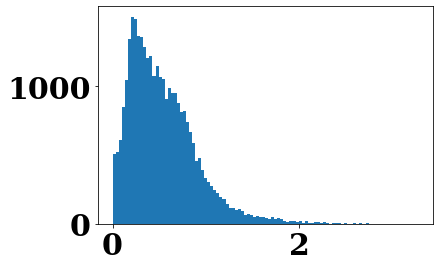

In [284]:
# load non-divergent BNN
epochs = 100000
batch_size = 4096
log_preprocessing_non_div = True
BNN_f = BNN
# NOTE: the above parameters have to be changed for different training

state, DL_non_div = train(epochs, batch_size, dataset=R_non_div, targets=non_div_amp, prior_prec=1/10, loadfile="checkpoint/log_softplus_split/4096b_weights100000", shuffle=False, log=log_preprocessing_non_div, 
                          BNN_f=BNN_f, inner_layers=[20,40,20])
bnn_non_div = BNN_f(R_non_div.shape[0], prior_prec=1/10, _map=False).to(device)
bnn_non_div.load_state_dict(state)

# use when using only one BNN for divergent area
# load divergent BNN
epochs = 100000
batch_size = 4096
log_preprocessing = True
BNN_f = BNN
# NOTE: the above parameters have to be changed for different training

state_div, DL_div = train(epochs,batch_size, dataset=R_div, targets=div_amp, prior_prec=1/10, loadfile="checkpoint/log_softplus_split/DIV_128b_weights100000", shuffle=False, log=log_preprocessing, BNN_f=BNN_f, inner_layers=[20,40,20])
bnn_div = BNN(R_non_div.shape[0], prior_prec=1/10, _map=False).to(device)
bnn_div.load_state_dict(state_div)

['checkpoint/log_softplus_split/30k_dBNNs/weights30000_area0', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area1', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area2', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area3', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area4', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area5', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area6', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area7', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area8', 'checkpoint/log_softplus_split/30k_dBNNs/weights30000_area9']
target mean:  2.18361206022418e-08 
target std:  5.504294684826989e-08
[[110.70544668   4.10503451   8.21006902 110.58650596]
 [131.64793946   7.9019886   15.80397721 130.70499065]
 [ 87.40693451  84.5335327   83.45222279  76.40391492]
 [ 64.26599974  45.87599427  45.10457908  64.81990696]
 [116.21876081  78.95231817  74.29503518 120.56620324]] (5, 4)
min:  0.00639583199554830

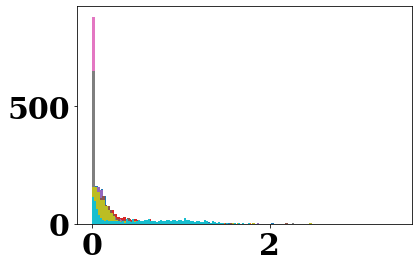

In [285]:
# use when using FKS pairs
# load divergent BNN
epochs = 100000
batch_size = 4096
log_preprocessing_div = True
BNN_f = BNN
# NOTE: the above parameters have to be changed for different training

dBNNS = divergent_BNNs_with_skips(dataset=weighted_data, targets=weighted_targets, map=False, log=log_preprocessing_div, BNN_f=BNN_f)
_ = dBNNS.train(epochs, batch_size, checkpoint_PATH=None, loadfiles="checkpoint/log_softplus_split/30k_dBNNs/", shuffle=False)

In [286]:
# preprocessing of non-divergent test data

valdata, valtargets = DL_non_div.test_data(dataset=test_R_non_div, targets=test_non_div_amp, shuffle=False)


using log preprocessing


# use when using only one BNN for divergent area

valdata_div, valtargets_div = DL_div.test_data(dataset=test_R_div, targets=test_div_amp, shuffle=False)

In [287]:
# predict non-divergent test data

_, sigma2_non_div, output_non_div = sample(sets=50, bnn=bnn_non_div, X=valdata, Y=valtargets, DL=DL_non_div, log=log_preprocessing_non_div) 


# use when using only one BNN for divergent area

_, sigma2_div, output_div = sample(sets=500, bnn=bnn_div, X=valdata_div, Y=valtargets_div, DL=DL_div, log=log_preprocessing_div) 
ratio_div = output_div/test_div_amp

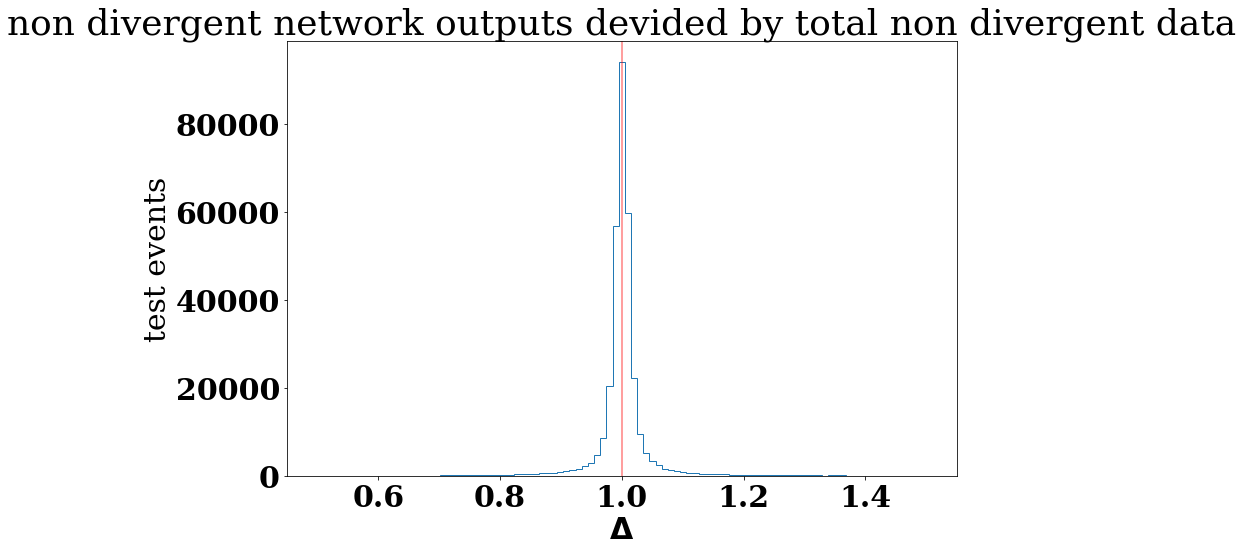

In [288]:
# consistency check - performance plot for non-divergent area

ratio_non_div = (output_non_div.mean(axis=0))/ test_non_div_amp
diff = (output_non_div.mean(axis=0)-test_non_div_amp)/test_non_div_amp

plt.figure(figsize=(12,8))
_ = plt.hist(ratio_non_div, bins=np.linspace(0.5,1.5,100), histtype="step")
plt.title("non divergent network outputs devided by total non divergent data")  
plt.ylabel("test events")
plt.xlabel("$\Delta$")
plt.axvline(1, alpha=0.5, c="r")
#plt.savefig("plots/cross_section/linear_no_act_split/non_div_test_delta.jpg", bbox_inches='tight')
plt.show()
#np.save("plots/cross_section/performance/log_softplus_split/one_div/non_divergent.npy", ratio_non_div)

In [67]:
# predict divergent test data

weighted_data = np.load("partitioned_data/R_div.npy")
test_weighted_data = np.load("partitioned_data/test_R_div.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")

ratio_div, sigma2_div, output_div = dBNNS.predict(X=test_weighted_data, Y=test_div_amp, sets=50)
ratio_div, sigma2_div, output_div = ratio_div.sum(axis=0), sigma2_div.sum(axis=0), output_div.sum(axis=0)

using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing
using log preprocessing


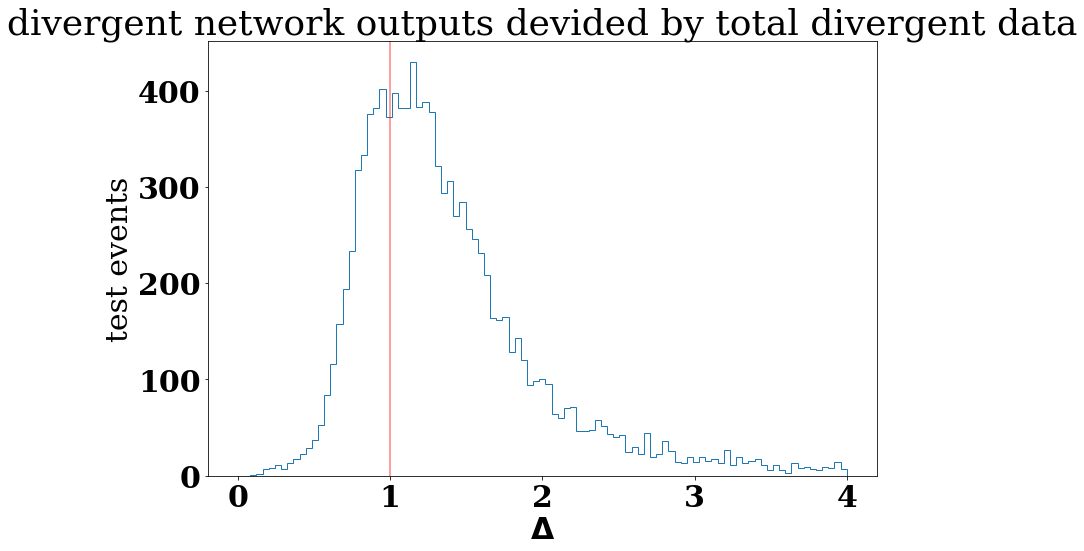

In [68]:
# consistency check - performance plot divergent area
ratio_div = output_div/test_div_amp

plt.figure(figsize=(12,8))
_ = plt.hist(ratio_div.mean(axis=0), bins=np.linspace(0,4,100), histtype="step")
plt.title("divergent network outputs devided by total divergent data")  
plt.ylabel("test events")
plt.xlabel("$\Delta$")
plt.axvline(1, alpha=0.5, c="r")
#plt.savefig("plots/cross_section/linear_no_act_split/div_test_delta.jpg")
plt.show()
#np.save("plots/cross_section/performance/linear_no_act_split/divergent.npy", ratio_div.mean(axis=0))

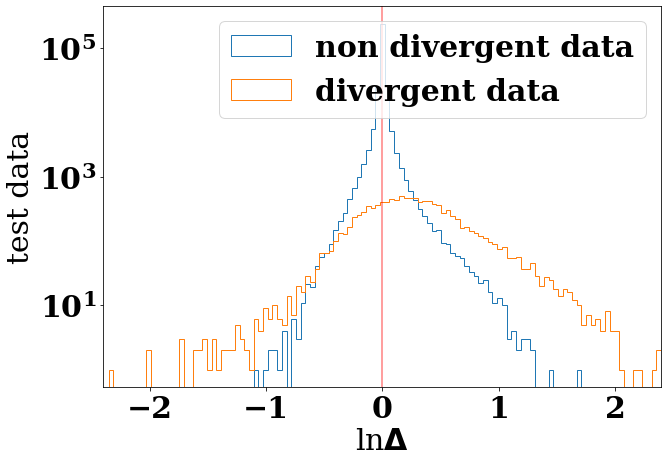

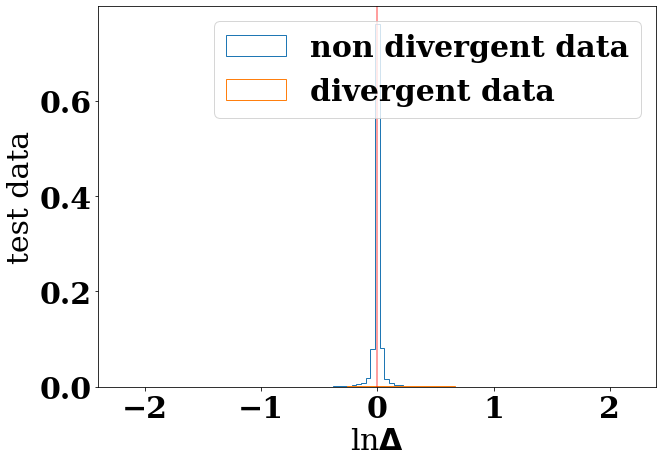

315399

In [19]:
# performance plot of divergent and non divergent areas combined

plt.figure(figsize=(10,7))
_ = plt.hist(np.log(ratio_non_div), bins=np.linspace(-3,3,150), histtype="step", label="non divergent data")
_ = plt.hist(np.log(ratio_div.mean(axis=0)), bins=np.linspace(-3,3,150), histtype="step", label="divergent data")
plt.ylabel("test data")
plt.xlabel("ln$\Delta$")
plt.legend(fontsize="medium")
plt.yscale("log")
#plt.text(-2,2e3, "MAP")
plt.axvline(0, c="red", alpha=0.5)
plt.xlim(-2.4, 2.4)
#plt.savefig("plots/cross_section/linear_no_act_split/log_performance_test_log_delta.jpg", bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,7))
hist,_ = np.histogram(np.log(np.abs(ratio_non_div)))
hist2,_ = np.histogram(np.log(np.abs(ratio_div.mean(axis=0))))
_ = plt.hist(np.log(ratio_non_div), bins=np.linspace(-3,3,150), histtype="step", label="non divergent data", weights=np.full(hist.sum(), 1/hist.sum()))
_ = plt.hist(np.log(ratio_div.mean(axis=0)), bins=np.linspace(-3,3,150), histtype="step", label="divergent data", weights=np.full(hist2.sum(), 1/hist.sum()))
plt.ylabel("test data")
plt.xlabel("ln$\Delta$")
plt.legend(fontsize="medium")
plt.xlim(-2.4, 2.4)
#plt.text(-2,1.2e5, "MAP")
plt.axvline(0, c="red", alpha=0.5)
#plt.savefig("plots/cross_section/linear_no_act_split/log_performance_test_delta.jpg", bbox_inches='tight')
plt.show()
hist.sum()

Filtered 974 of 326465 events
amplitude error:  [1.51350761 1.0342987  1.72322807 1.0754908  1.06204403 1.84390548
 1.16872764 1.1797728  1.17272304 1.2396317  0.67465841 1.1328961
 2.30015724 0.69438737 2.16120666 1.84399538 2.24402504 1.33672636
 2.4269406  1.17041613]
events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_tru

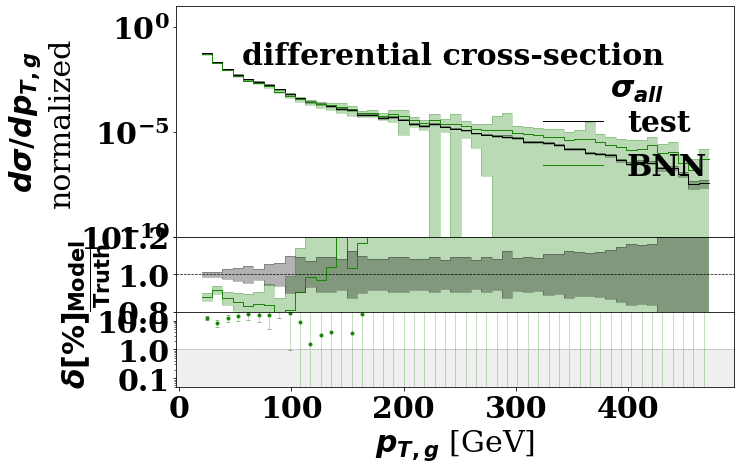

runtime: 89.16779 s


In [244]:
# begin plotting kinematic distributions

test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_R_div = np.load("partitioned_data/test_R_div.npy")
R_div = np.load("partitioned_data/R_div.npy")

R_all_training = np.concatenate((R_non_div, R_div), axis=0)
R_all = np.concatenate((test_R_non_div, test_R_div), axis=0)

test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

amp_all = np.concatenate((test_non_div_amp, test_div_amp), axis=0)
#amp_all = np.concatenate((non_div_amp, div_amp), axis=0)

all_output = np.concatenate((output_non_div, output_div), axis=1)
sigma2_all = np.concatenate((sigma2_non_div,sigma2_div), axis=1)


#filter
filter = get_filter(all_output, sigma2_all,8,20)
all_output = all_output[:,filter]
sigma2_all = sigma2_all[:,filter]


# savepath
save = "linear_no_act_split/vs_test"
# additional filename tag for BNNs which use filtered data
filtered = "filtered"
# additional filname tag for BNNs with map
map = ""
# additional filename tag for reduced training data size
less = "" 
# label of "true" distribution
true_label="test"
# whether to normalize the distributions individually
normalize=False
# text in figure
inner_text=None


# NOTE: obs_true can be changes to predict on R_all_training if the "true" distribution should consist of training data
obs_true = observables(R_all)
obs = observables(R_all)


p_t_true = obs_true[0]
p_t = obs[0][filter]
bin_mean, bin_var, bin_true = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, 
                                                 savepath="plots/cross_section/{}/p_T{}{}{}.jpg".format(save, filtered, map, less) , xlabel="p_{T,g}", unit="GeV", errortype="all",
                                                 normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

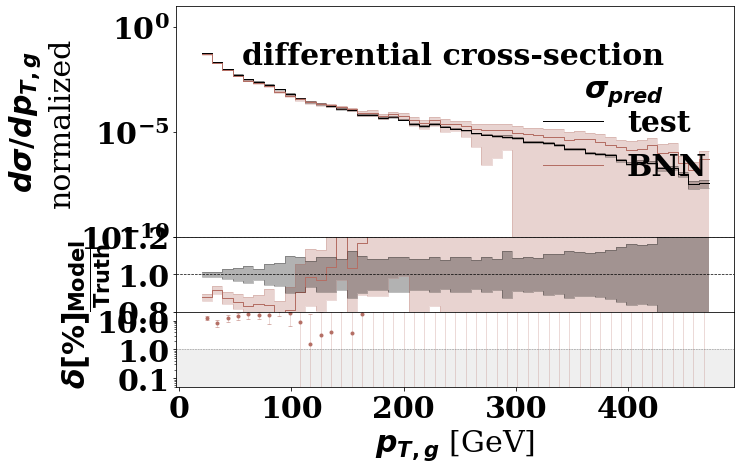

runtime: 2.06352 s


In [245]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_std.jpg".format(save, filtered, map, less),
                       xlabel="p_{T,g}", unit="GeV", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

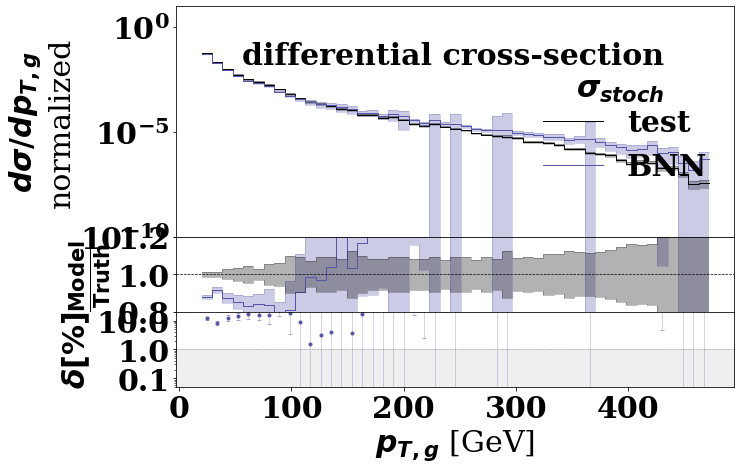

runtime: 2.16655 s


In [246]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_bnn.jpg".format(save, filtered, map, less) , 
                       xlabel="p_{T,g}", unit="GeV", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

amplitude error:  [2.45448014 0.48267503 1.08704513 0.40952672 0.29529541 1.34597779
 1.32525662 0.33992172 0.26575921 0.24041534 0.20238924 0.21678567
 0.26545939 0.51107313 1.20630561 0.36995322 1.10750871 0.33156281
 1.7646635  0.37027424]
events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 

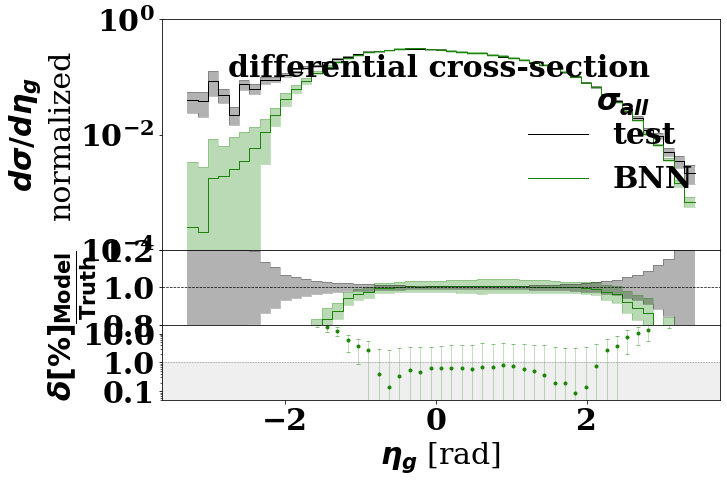

runtime: 87.31012 s


In [248]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,1), inner_text=inner_text)

events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 2.81672874e-03 3.36222065e-03 3.77002374e-03 4.53194486e-03
 4.78843856e-03 5.61229831e-03 6.39255904e-03 6.95322400e-03
 7.67181769e-03 8.52027911e-03 8.68985477e-03 9.12067536e-03
 9.49156365e-03 9.69720781e-03 9.71153225e-03 9.36867314e-03


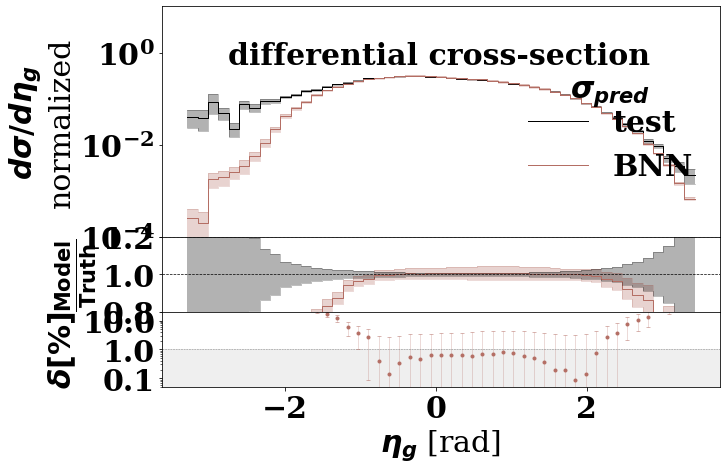

runtime: 2.08086 s


In [249]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,10), inner_text=inner_text)

events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 2.81672874e-03 3.36222065e-03 3.77002374e-03 4.53194486e-03
 4.78843856e-03 5.61229831e-03 6.39255904e-03 6.95322400e-03
 7.67181769e-03 8.52027911e-03 8.68985477e-03 9.12067536e-03
 9.49156365e-03 9.69720781e-03 9.71153225e-03 9.36867314e-03


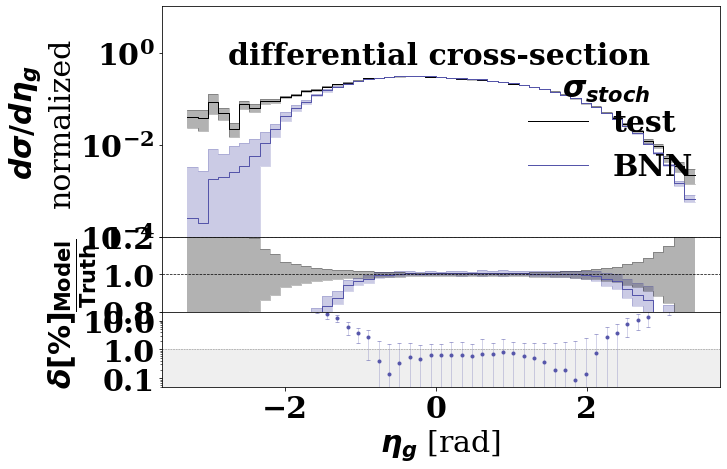

runtime: 2.01088 s


In [250]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,10), inner_text=inner_text)

amplitude error:  [0.07961415 2.67447755 0.22515125 0.10313769 0.05982834 2.46838733
 0.15096313 0.24013119 0.07237169 2.06013706 0.08142268 0.11586258
 1.0501071  0.06954102 1.24818846 0.14309236 0.22615521 2.0020686
 2.0414494  7.5474125 ]
events:  [18437 18017 17772 17389 17363 17181 16858 17182 17019 15996 15079 14031
 12923 12029 11017 10034  9170  8211  7417  6778  6024  5477  4915  4167
  3776  3230  2932  2509  2139  1829  1533  1341  1080   903   757   658
   498   420   340   268   195   183   141   100    63    48    34    16
     7     2     1     0     0     0     0     0     1     0     0     0
     0     0     0     0     0     0     0     0     1]
true events:  [18460 18041 17799 17407 17394 17214 16884 17214 17063 16033 15118 14077
 12965 12066 11046 10064  9200  8246  7444  6812  6048  5499  4942  4191
  3795  3257  2946  2532  2156  1849  1544  1356  1091   918   768   665
   503   436   343   269   202   187   143   102    63    50    35    16
     7     2     1    

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


saved:  plots/cross_section/linear_no_act_split/vs_test/eta_difffiltered.jpg


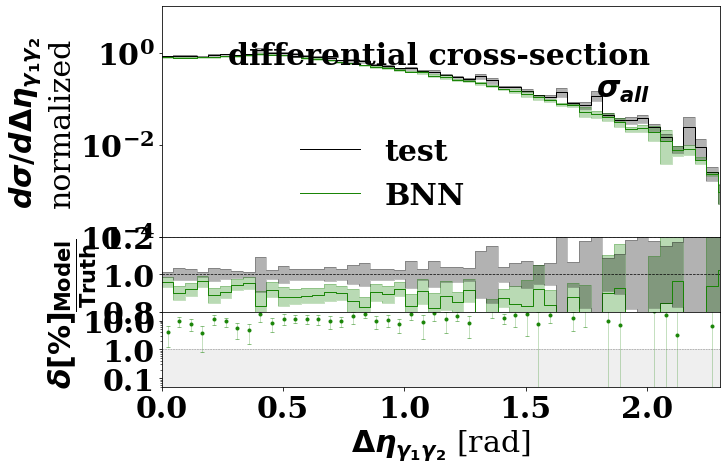

runtime: 87.00065 s


In [251]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=70, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", ylim=(1e-4,10), xlim=(0,2.3), inner_text=inner_text)

events:  [25859 25103 24564 24318 23881 24083 23199 21151 19108 16915 15116 13319
 11421  9981  8598  7468  6147  5146  4348  3575  2861  2244  1810  1368
  1085   827   606   452   314   246   169   101    67    26    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


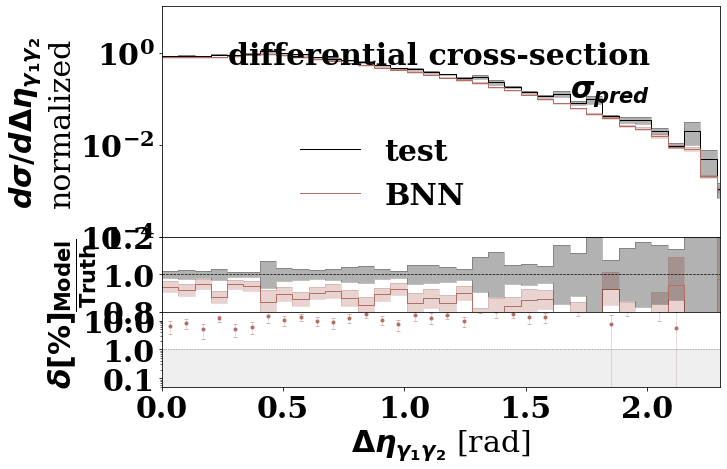

runtime: 2.14839 s


In [252]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", ylim=(1e-4,10), xlim=(0,2.3), 
                      inner_text=inner_text)

events:  [25859 25103 24564 24318 23881 24083 23199 21151 19108 16915 15116 13319
 11421  9981  8598  7468  6147  5146  4348  3575  2861  2244  1810  1368
  1085   827   606   452   314   246   169   101    67    26    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


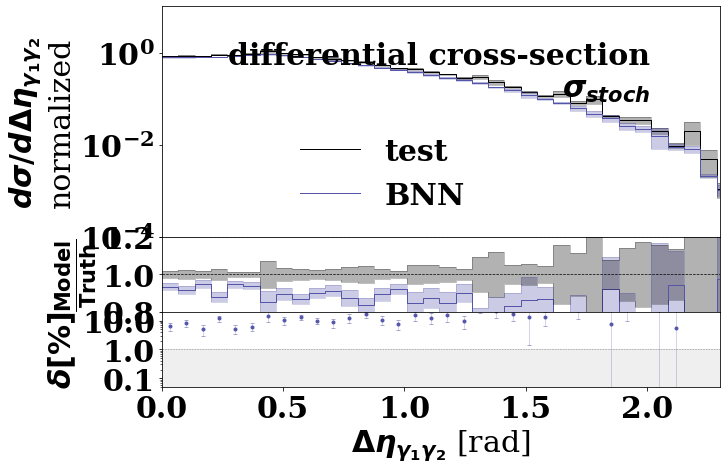

runtime: 2.15300 s


In [253]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", 
                       ylim=(1e-4,10), xlim=(0,2.3), inner_text=inner_text)

amplitude error:  [0.05941323 0.02337942 0.02462905 0.0568759  0.02024909 0.02610945
 0.02539866 0.06457559 0.02521443 0.13014419 0.01966793 0.06038555
 0.0240059  0.07892194 0.02734544 0.02137517 0.03393339 0.02607432
 0.03179158 0.10848345]
events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  

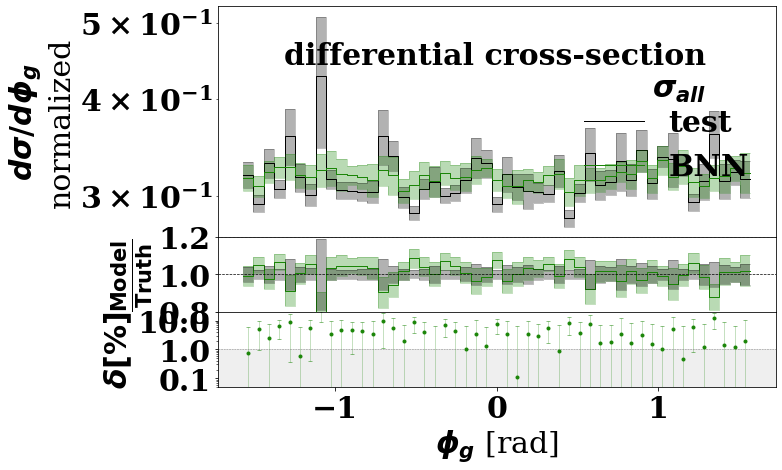

runtime: 88.03997 s


In [260]:
phi_true = obs_true[2]
phi = obs[2][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

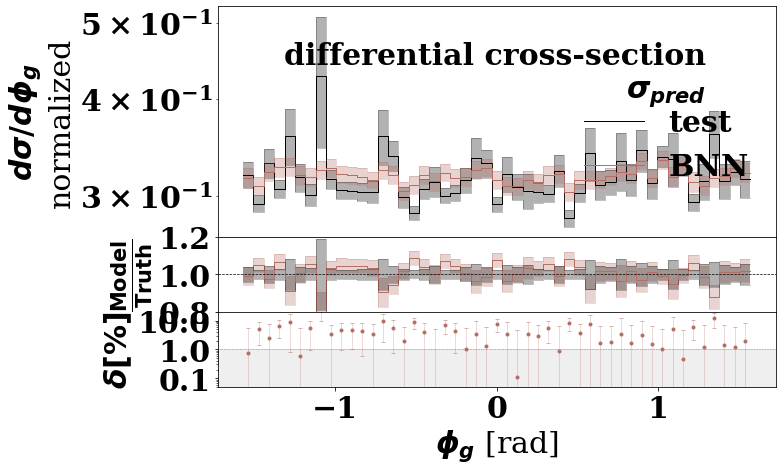

runtime: 2.17535 s


In [261]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="pred", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

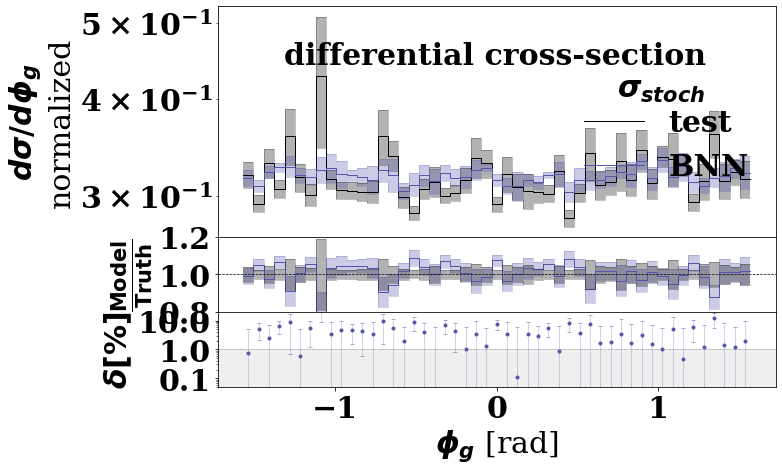

runtime: 2.11301 s


In [262]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="stoch", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

amplitude error:  [ 1.28259535  2.21307825  0.82195276  1.48325561  2.39089692  0.9018675
 10.84800852  1.68351247  1.32686588  1.29596581  1.16506978  1.3323584
  2.6636877   1.51764181  4.97497445  1.01947498  0.92568964  6.82846048
  1.1969939   5.75015347]
events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


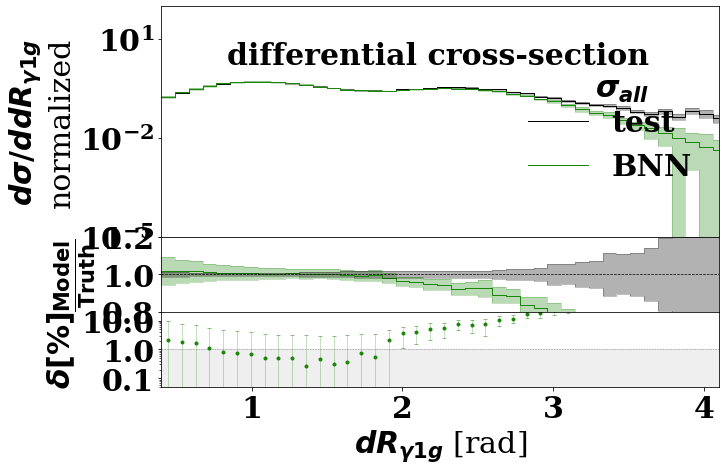

runtime: 90.81321 s


In [257]:
dR_true = obs_true[3]
dR = obs[3][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00941884 0.00850014 0.00749223
 0.0067394  0.00609268 0.00577908 0.00567999 0.00555649 0.00617949
 0.00646172 0.0068508  0.00716662 0.00713047 0.00695367 0.0063962
 0.00614705 0.00501412 0.00473014 0.00374502 0.00345834 0.00279569
 0.0024002  0.00208516 0.0019887

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


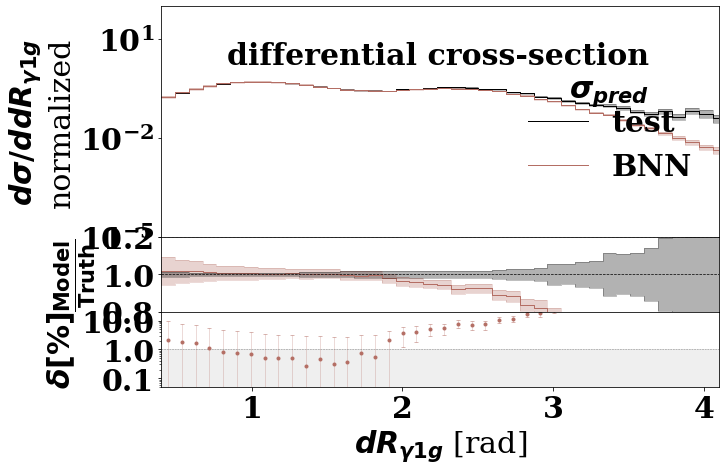

runtime: 2.20863 s


In [258]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="pred", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, 
                       true_label=true_label, inner_text=inner_text)

events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00941884 0.00850014 0.00749223
 0.0067394  0.00609268 0.00577908 0.00567999 0.00555649 0.00617949
 0.00646172 0.0068508  0.00716662 0.00713047 0.00695367 0.0063962
 0.00614705 0.00501412 0.00473014 0.00374502 0.00345834 0.00279569
 0.0024002  0.00208516 0.0019887

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


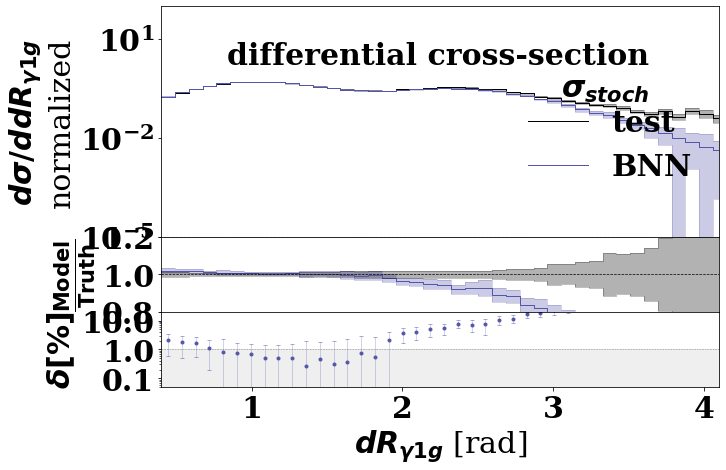

runtime: 2.22723 s


In [259]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="stoch", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, 
                       true_label=true_label, inner_text=inner_text)

## Divergent and non-divergent area on their own

# non-divergent

Filtered 974 of 326465 events
amplitude error:  [1.51350761 1.0342987  1.72322807 1.0754908  1.06204403 1.84390548
 1.16872764 1.1797728  1.17272304 1.2396317  0.67465841 1.1328961
 2.30015724 0.69438737 2.16120666 1.84399538 2.24402504 1.33672636
 2.4269406  1.17041613]
events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_tru

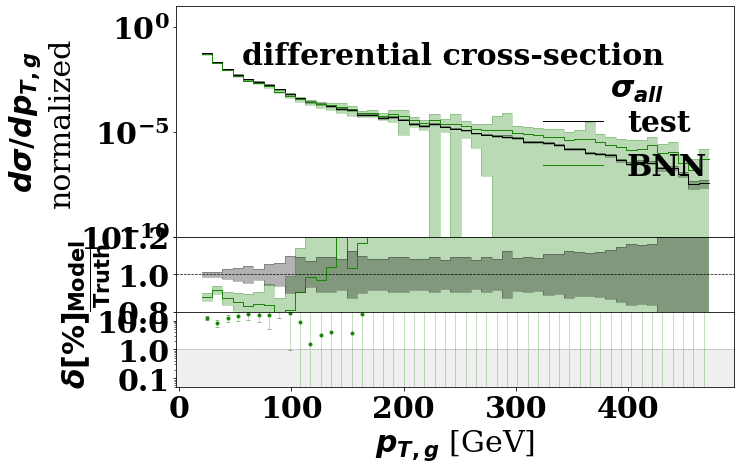

runtime: 89.16779 s


In [244]:
# begin plotting kinematic distributions

test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_R_div = np.load("partitioned_data/test_R_div.npy")
R_div = np.load("partitioned_data/R_div.npy")

R_all_training = R_non_div
R_all = test_R_non_div

test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

amp_all = test_non_div_amp
#amp_all = non_div_amp

all_output = output_non_div
sigma2_all = sigma2_non_div


#filter
filter = get_filter(all_output, sigma2_all,8,20)
all_output = all_output[:,filter]
sigma2_all = sigma2_all[:,filter]


# savepath
save = "tmp"
# additional filename tag for BNNs which use filtered data
filtered = "filtered"
# additional filname tag for BNNs with map
map = ""
# additional filename tag for reduced training data size
less = "" 
# label of "true" distribution
true_label="test"
# whether to normalize the distributions individually
normalize=False
# text in figure
inner_text=None


# NOTE: obs_true can be changes to predict on R_all_training if the "true" distribution should consist of training data
obs_true = observables(R_all)
obs = observables(R_all)


p_t_true = obs_true[0]
p_t = obs[0][filter]
bin_mean, bin_var, bin_true = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, 
                                                 savepath="plots/cross_section/{}/p_T{}{}{}.jpg".format(save, filtered, map, less) , xlabel="p_{T,g}", unit="GeV", errortype="all",
                                                 normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

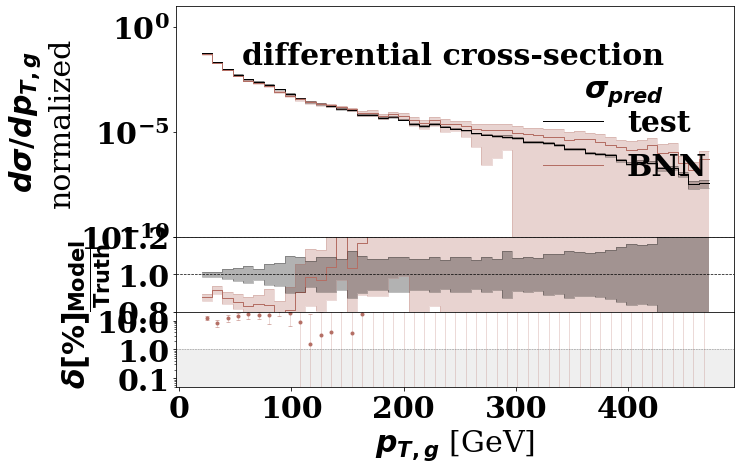

runtime: 2.06352 s


In [245]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_std.jpg".format(save, filtered, map, less),
                       xlabel="p_{T,g}", unit="GeV", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

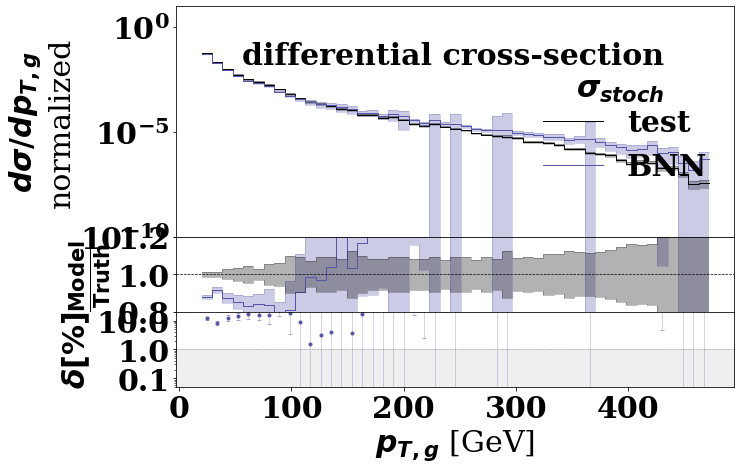

runtime: 2.16655 s


In [246]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_bnn.jpg".format(save, filtered, map, less) , 
                       xlabel="p_{T,g}", unit="GeV", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

amplitude error:  [2.45448014 0.48267503 1.08704513 0.40952672 0.29529541 1.34597779
 1.32525662 0.33992172 0.26575921 0.24041534 0.20238924 0.21678567
 0.26545939 0.51107313 1.20630561 0.36995322 1.10750871 0.33156281
 1.7646635  0.37027424]
events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 

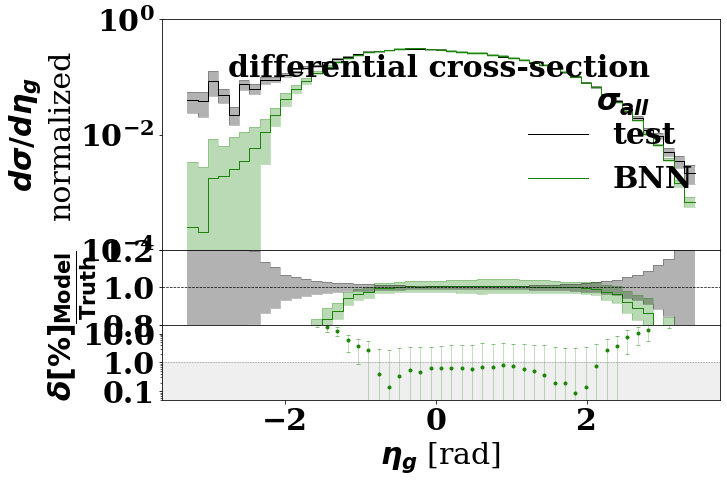

runtime: 87.31012 s


In [248]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,1), inner_text=inner_text)

events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 2.81672874e-03 3.36222065e-03 3.77002374e-03 4.53194486e-03
 4.78843856e-03 5.61229831e-03 6.39255904e-03 6.95322400e-03
 7.67181769e-03 8.52027911e-03 8.68985477e-03 9.12067536e-03
 9.49156365e-03 9.69720781e-03 9.71153225e-03 9.36867314e-03


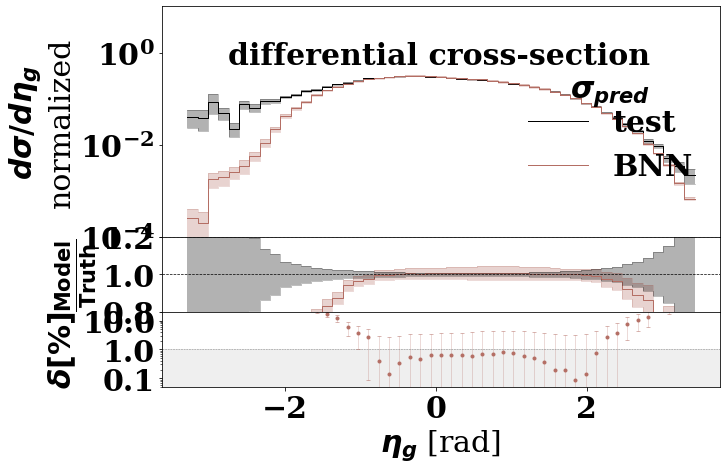

runtime: 2.08086 s


In [249]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,10), inner_text=inner_text)

events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 2.81672874e-03 3.36222065e-03 3.77002374e-03 4.53194486e-03
 4.78843856e-03 5.61229831e-03 6.39255904e-03 6.95322400e-03
 7.67181769e-03 8.52027911e-03 8.68985477e-03 9.12067536e-03
 9.49156365e-03 9.69720781e-03 9.71153225e-03 9.36867314e-03


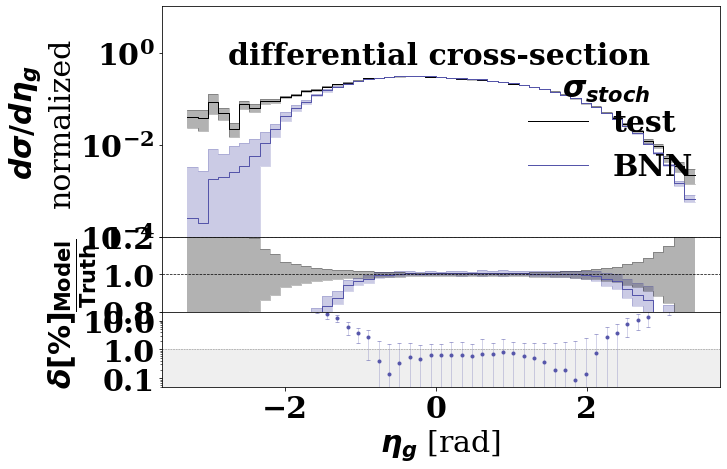

runtime: 2.01088 s


In [250]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,10), inner_text=inner_text)

amplitude error:  [0.07961415 2.67447755 0.22515125 0.10313769 0.05982834 2.46838733
 0.15096313 0.24013119 0.07237169 2.06013706 0.08142268 0.11586258
 1.0501071  0.06954102 1.24818846 0.14309236 0.22615521 2.0020686
 2.0414494  7.5474125 ]
events:  [18437 18017 17772 17389 17363 17181 16858 17182 17019 15996 15079 14031
 12923 12029 11017 10034  9170  8211  7417  6778  6024  5477  4915  4167
  3776  3230  2932  2509  2139  1829  1533  1341  1080   903   757   658
   498   420   340   268   195   183   141   100    63    48    34    16
     7     2     1     0     0     0     0     0     1     0     0     0
     0     0     0     0     0     0     0     0     1]
true events:  [18460 18041 17799 17407 17394 17214 16884 17214 17063 16033 15118 14077
 12965 12066 11046 10064  9200  8246  7444  6812  6048  5499  4942  4191
  3795  3257  2946  2532  2156  1849  1544  1356  1091   918   768   665
   503   436   343   269   202   187   143   102    63    50    35    16
     7     2     1    

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


saved:  plots/cross_section/linear_no_act_split/vs_test/eta_difffiltered.jpg


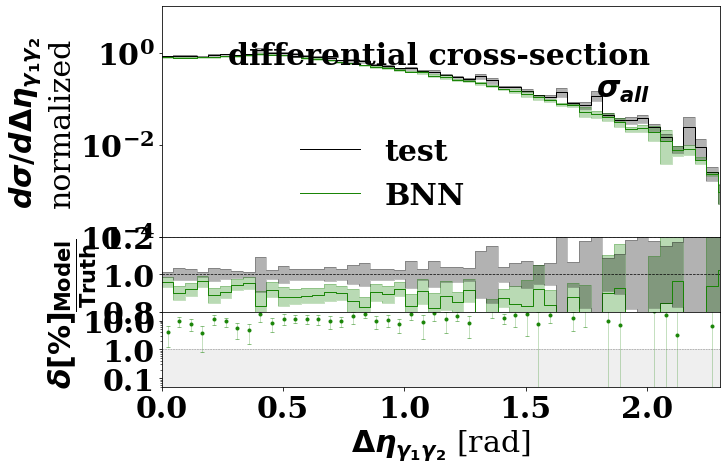

runtime: 87.00065 s


In [251]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=70, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", ylim=(1e-4,10), xlim=(0,2.3), inner_text=inner_text)

events:  [25859 25103 24564 24318 23881 24083 23199 21151 19108 16915 15116 13319
 11421  9981  8598  7468  6147  5146  4348  3575  2861  2244  1810  1368
  1085   827   606   452   314   246   169   101    67    26    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


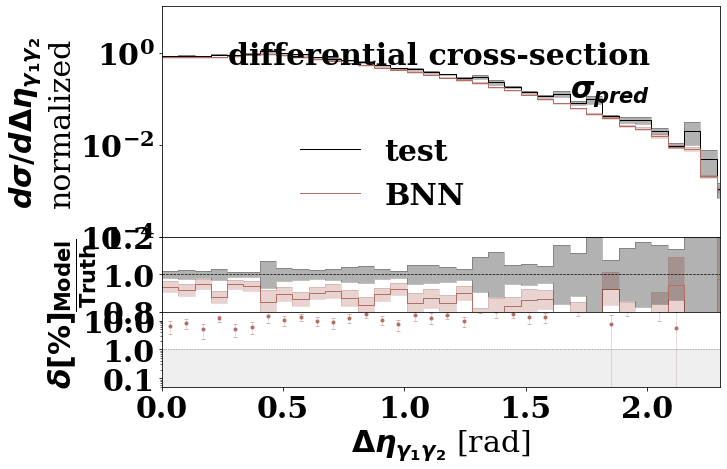

runtime: 2.14839 s


In [252]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", ylim=(1e-4,10), xlim=(0,2.3), 
                      inner_text=inner_text)

events:  [25859 25103 24564 24318 23881 24083 23199 21151 19108 16915 15116 13319
 11421  9981  8598  7468  6147  5146  4348  3575  2861  2244  1810  1368
  1085   827   606   452   314   246   169   101    67    26    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


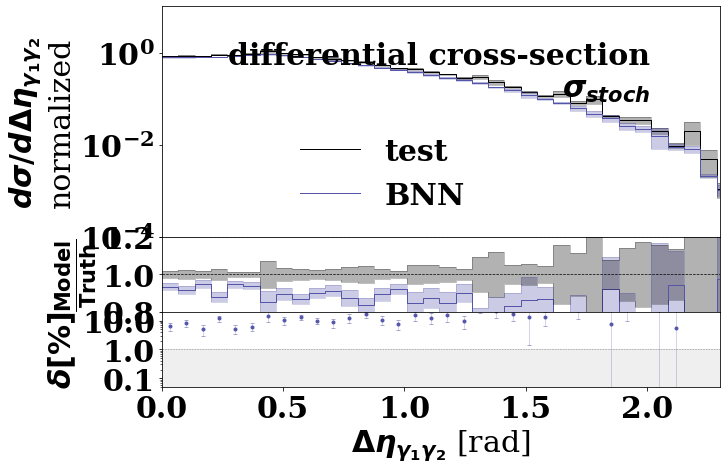

runtime: 2.15300 s


In [253]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", 
                       ylim=(1e-4,10), xlim=(0,2.3), inner_text=inner_text)

amplitude error:  [0.05941323 0.02337942 0.02462905 0.0568759  0.02024909 0.02610945
 0.02539866 0.06457559 0.02521443 0.13014419 0.01966793 0.06038555
 0.0240059  0.07892194 0.02734544 0.02137517 0.03393339 0.02607432
 0.03179158 0.10848345]
events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  

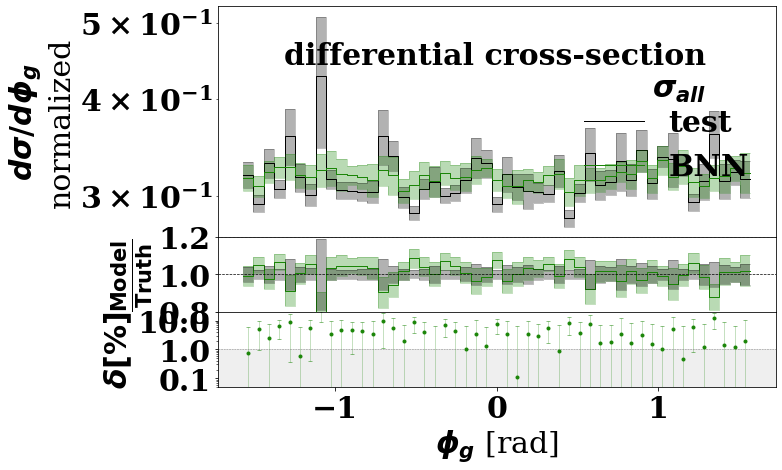

runtime: 88.03997 s


In [260]:
phi_true = obs_true[2]
phi = obs[2][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

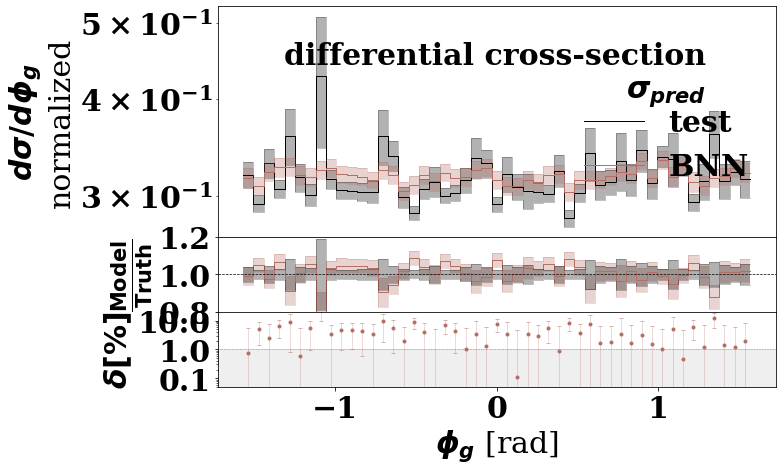

runtime: 2.17535 s


In [261]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="pred", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

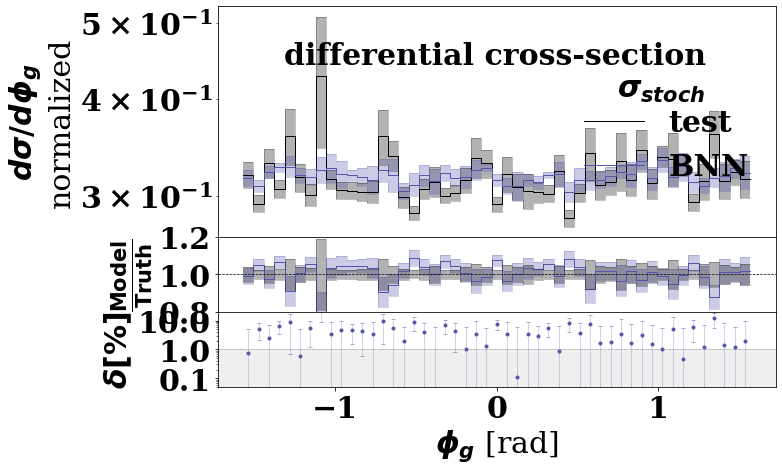

runtime: 2.11301 s


In [262]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="stoch", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

amplitude error:  [ 1.28259535  2.21307825  0.82195276  1.48325561  2.39089692  0.9018675
 10.84800852  1.68351247  1.32686588  1.29596581  1.16506978  1.3323584
  2.6636877   1.51764181  4.97497445  1.01947498  0.92568964  6.82846048
  1.1969939   5.75015347]
events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


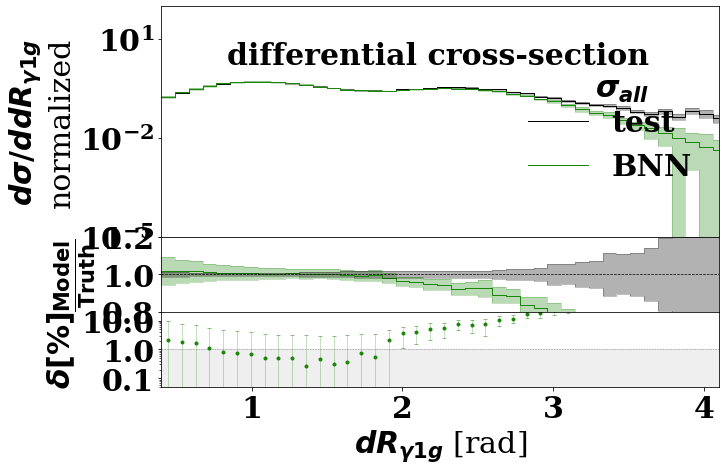

runtime: 90.81321 s


In [257]:
dR_true = obs_true[3]
dR = obs[3][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00941884 0.00850014 0.00749223
 0.0067394  0.00609268 0.00577908 0.00567999 0.00555649 0.00617949
 0.00646172 0.0068508  0.00716662 0.00713047 0.00695367 0.0063962
 0.00614705 0.00501412 0.00473014 0.00374502 0.00345834 0.00279569
 0.0024002  0.00208516 0.0019887

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


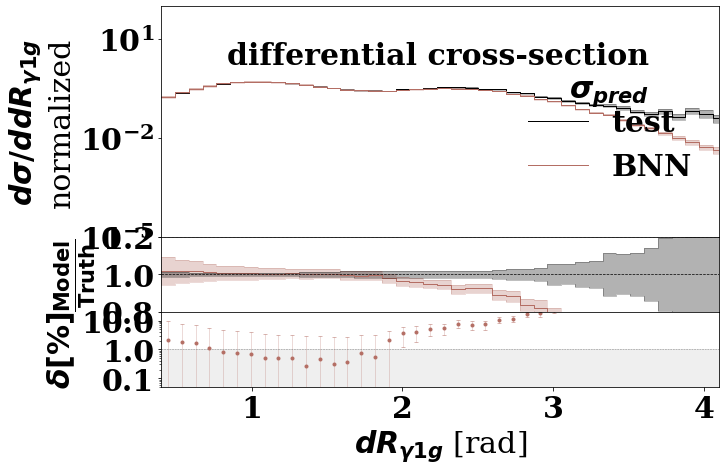

runtime: 2.20863 s


In [258]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="pred", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, 
                       true_label=true_label, inner_text=inner_text)

events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00941884 0.00850014 0.00749223
 0.0067394  0.00609268 0.00577908 0.00567999 0.00555649 0.00617949
 0.00646172 0.0068508  0.00716662 0.00713047 0.00695367 0.0063962
 0.00614705 0.00501412 0.00473014 0.00374502 0.00345834 0.00279569
 0.0024002  0.00208516 0.0019887

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


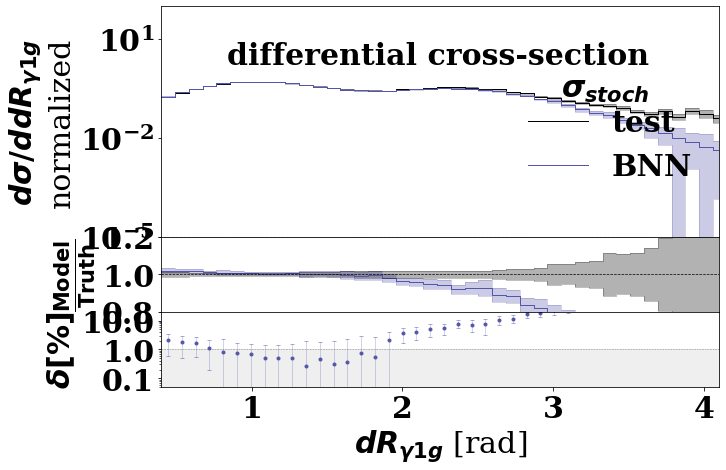

runtime: 2.22723 s


In [259]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="stoch", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, 
                       true_label=true_label, inner_text=inner_text)

# Divergent region

Filtered 974 of 326465 events
amplitude error:  [1.51350761 1.0342987  1.72322807 1.0754908  1.06204403 1.84390548
 1.16872764 1.1797728  1.17272304 1.2396317  0.67465841 1.1328961
 2.30015724 0.69438737 2.16120666 1.84399538 2.24402504 1.33672636
 2.4269406  1.17041613]
events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_tru

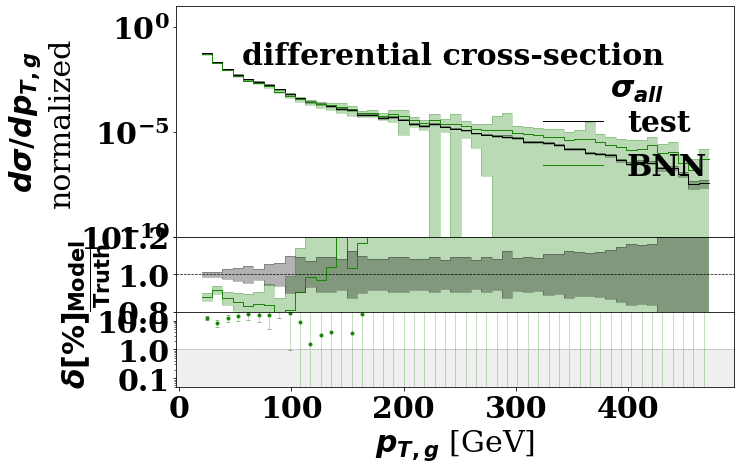

runtime: 89.16779 s


In [244]:
# begin plotting kinematic distributions

test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_R_div = np.load("partitioned_data/test_R_div.npy")
R_div = np.load("partitioned_data/R_div.npy")

R_all_training = R_div
R_all = test_R_div

test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

amp_all = test_div_amp
#amp_all = np.concatenate((non_div_amp, div_amp), axis=0)

all_output = output_div
sigma2_all = sigma2_div


#filter
filter = get_filter(all_output, sigma2_all,8,20)
all_output = all_output[:,filter]
sigma2_all = sigma2_all[:,filter]


# savepath
save = "tmp"
# additional filename tag for BNNs which use filtered data
filtered = "filtered"
# additional filname tag for BNNs with map
map = ""
# additional filename tag for reduced training data size
less = "" 
# label of "true" distribution
true_label="test"
# whether to normalize the distributions individually
normalize=False
# text in figure
inner_text=None


# NOTE: obs_true can be changes to predict on R_all_training if the "true" distribution should consist of training data
obs_true = observables(R_all)
obs = observables(R_all)


p_t_true = obs_true[0]
p_t = obs[0][filter]
bin_mean, bin_var, bin_true = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, 
                                                 savepath="plots/cross_section/{}/p_T{}{}{}.jpg".format(save, filtered, map, less) , xlabel="p_{T,g}", unit="GeV", errortype="all",
                                                 normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

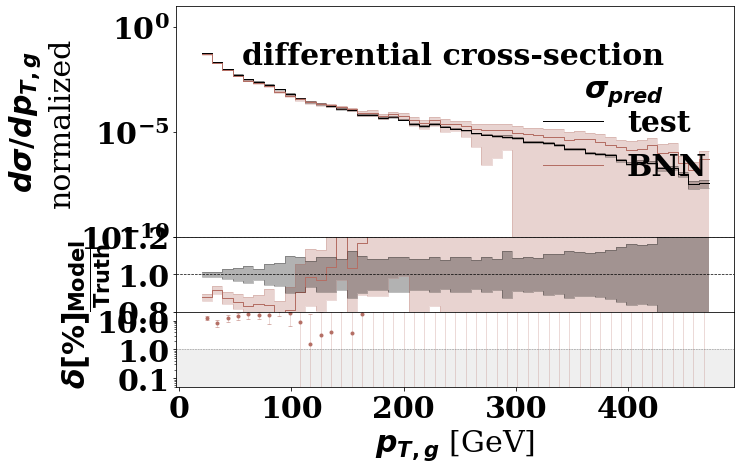

runtime: 2.06352 s


In [245]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_std.jpg".format(save, filtered, map, less),
                       xlabel="p_{T,g}", unit="GeV", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

events:  [101535  69965  46568  30837  21420  15667   9973   6010   3707   2497
   1871   1588   1321   1148   1061    912    867    753    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

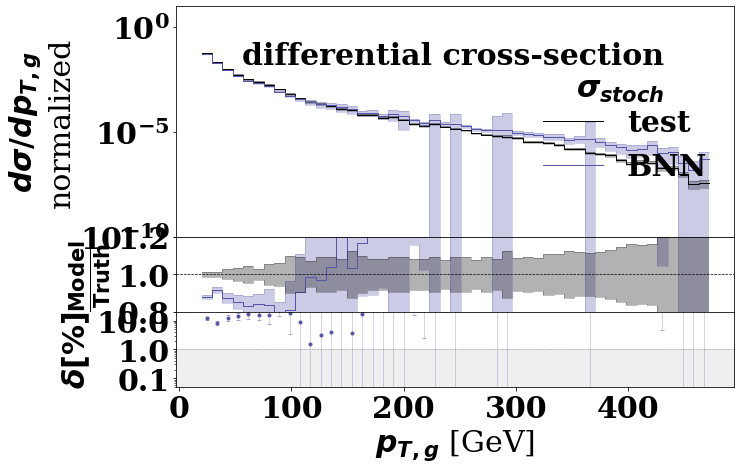

runtime: 2.16655 s


In [246]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_bnn.jpg".format(save, filtered, map, less) , 
                       xlabel="p_{T,g}", unit="GeV", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-10, 10), inner_text=inner_text)

amplitude error:  [2.45448014 0.48267503 1.08704513 0.40952672 0.29529541 1.34597779
 1.32525662 0.33992172 0.26575921 0.24041534 0.20238924 0.21678567
 0.26545939 0.51107313 1.20630561 0.36995322 1.10750871 0.33156281
 1.7646635  0.37027424]
events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 

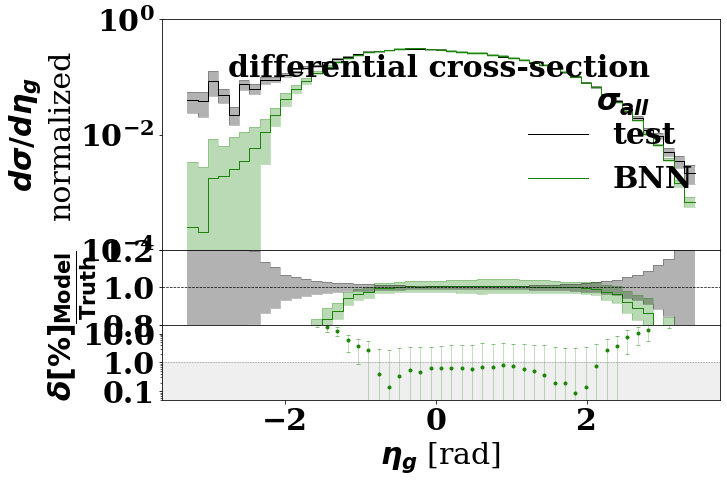

runtime: 87.31012 s


In [248]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,1), inner_text=inner_text)

events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 2.81672874e-03 3.36222065e-03 3.77002374e-03 4.53194486e-03
 4.78843856e-03 5.61229831e-03 6.39255904e-03 6.95322400e-03
 7.67181769e-03 8.52027911e-03 8.68985477e-03 9.12067536e-03
 9.49156365e-03 9.69720781e-03 9.71153225e-03 9.36867314e-03


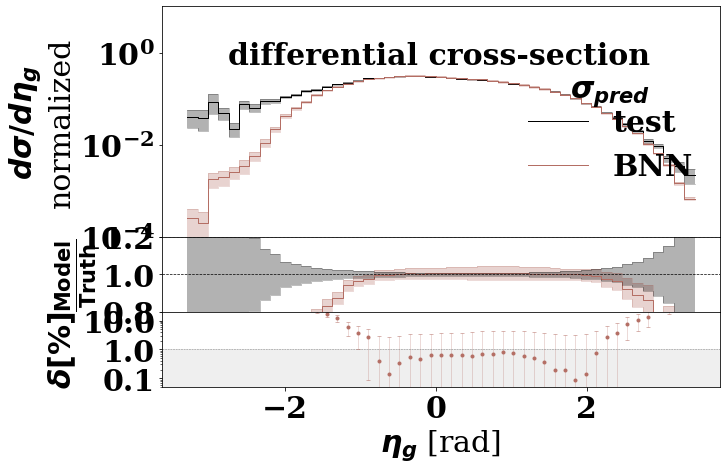

runtime: 2.08086 s


In [249]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,10), inner_text=inner_text)

events:  [    2     1    12    13    20    32    54    93   175   357   615   952
  1444  2124  3146  4411  5834  7712  9757 11947 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
true events:  [   10    10    31    37    36    75   112   186   272   481   729  1071
  1519  2190  3198  4434  5850  7721  9757 11948 14288 16449 18193 19060
 20186 20459 20887 20509 20176 18931 17002 15027 12930 10678  8607  6655
  5124  3768  2655  1908  1219   836   524   344   186   101    56    22
    10]
bin_true:  [1.23244919e-03 1.17304395e-03 2.67610196e-03 1.51662448e-03
 6.92312622e-04 2.32471374e-03 1.95285930e-03 2.70856889e-03
 2.81672874e-03 3.36222065e-03 3.77002374e-03 4.53194486e-03
 4.78843856e-03 5.61229831e-03 6.39255904e-03 6.95322400e-03
 7.67181769e-03 8.52027911e-03 8.68985477e-03 9.12067536e-03
 9.49156365e-03 9.69720781e-03 9.71153225e-03 9.36867314e-03


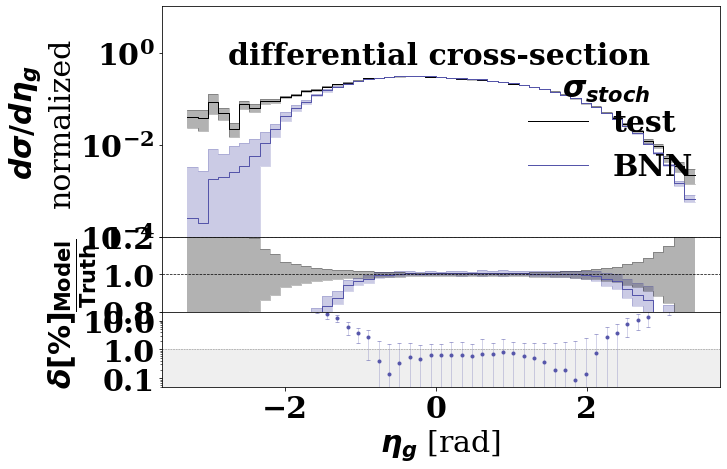

runtime: 2.01088 s


In [250]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, ylim=(1e-4,10), inner_text=inner_text)

amplitude error:  [0.07961415 2.67447755 0.22515125 0.10313769 0.05982834 2.46838733
 0.15096313 0.24013119 0.07237169 2.06013706 0.08142268 0.11586258
 1.0501071  0.06954102 1.24818846 0.14309236 0.22615521 2.0020686
 2.0414494  7.5474125 ]
events:  [18437 18017 17772 17389 17363 17181 16858 17182 17019 15996 15079 14031
 12923 12029 11017 10034  9170  8211  7417  6778  6024  5477  4915  4167
  3776  3230  2932  2509  2139  1829  1533  1341  1080   903   757   658
   498   420   340   268   195   183   141   100    63    48    34    16
     7     2     1     0     0     0     0     0     1     0     0     0
     0     0     0     0     0     0     0     0     1]
true events:  [18460 18041 17799 17407 17394 17214 16884 17214 17063 16033 15118 14077
 12965 12066 11046 10064  9200  8246  7444  6812  6048  5499  4942  4191
  3795  3257  2946  2532  2156  1849  1544  1356  1091   918   768   665
   503   436   343   269   202   187   143   102    63    50    35    16
     7     2     1    

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


saved:  plots/cross_section/linear_no_act_split/vs_test/eta_difffiltered.jpg


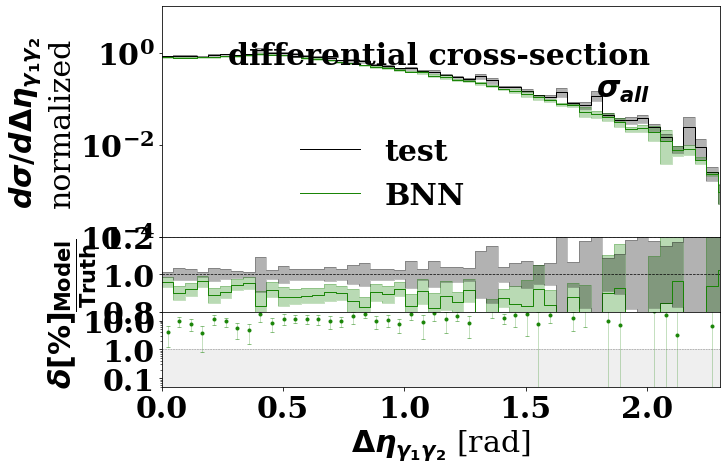

runtime: 87.00065 s


In [251]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=70, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", ylim=(1e-4,10), xlim=(0,2.3), inner_text=inner_text)

events:  [25859 25103 24564 24318 23881 24083 23199 21151 19108 16915 15116 13319
 11421  9981  8598  7468  6147  5146  4348  3575  2861  2244  1810  1368
  1085   827   606   452   314   246   169   101    67    26    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


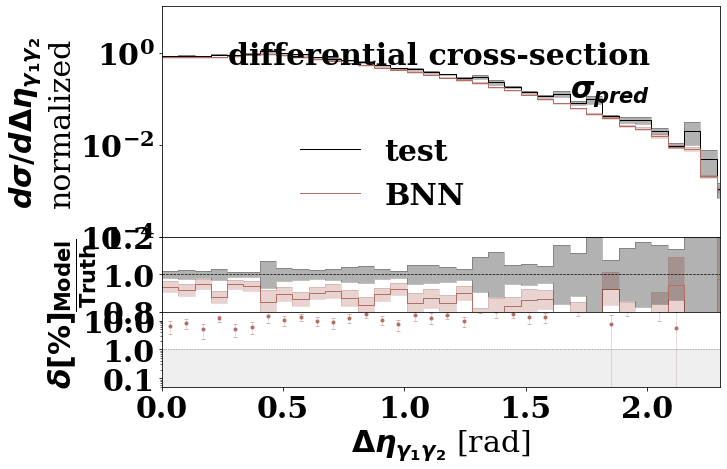

runtime: 2.14839 s


In [252]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="pred", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", ylim=(1e-4,10), xlim=(0,2.3), 
                      inner_text=inner_text)

events:  [25859 25103 24564 24318 23881 24083 23199 21151 19108 16915 15116 13319
 11421  9981  8598  7468  6147  5146  4348  3575  2861  2244  1810  1368
  1085   827   606   452   314   246   169   101    67    26    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


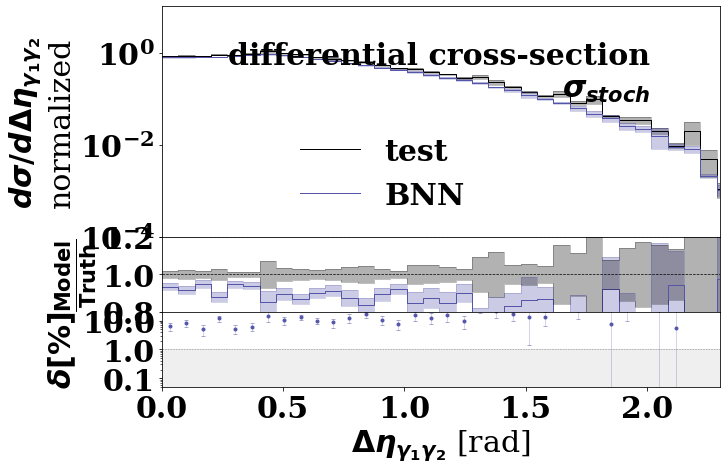

runtime: 2.15300 s


In [253]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="stoch", normalize=normalize, stoch_error=True, true_label=true_label, legend_pos="best", 
                       ylim=(1e-4,10), xlim=(0,2.3), inner_text=inner_text)

amplitude error:  [0.05941323 0.02337942 0.02462905 0.0568759  0.02024909 0.02610945
 0.02539866 0.06457559 0.02521443 0.13014419 0.01966793 0.06038555
 0.0240059  0.07892194 0.02734544 0.02137517 0.03393339 0.02607432
 0.03179158 0.10848345]
events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  

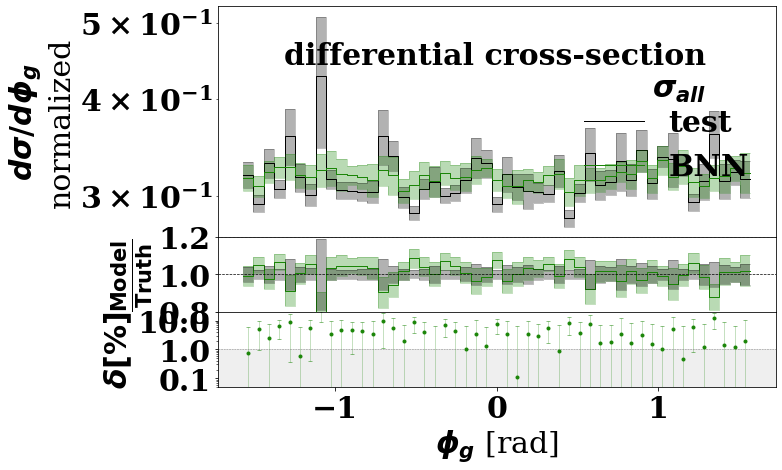

runtime: 88.03997 s


In [260]:
phi_true = obs_true[2]
phi = obs[2][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

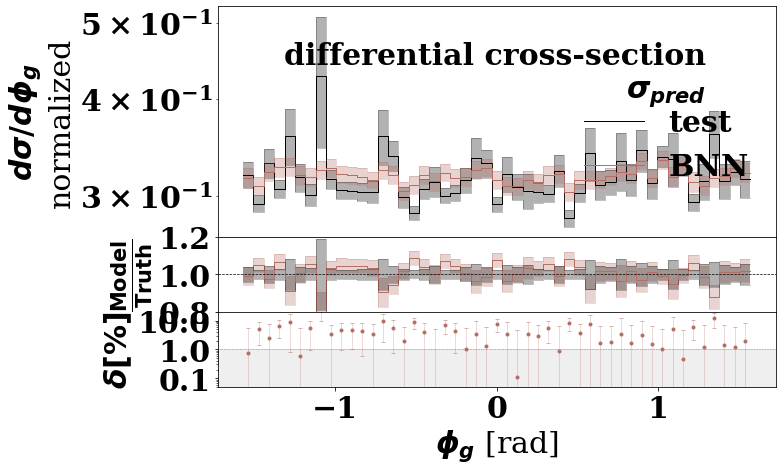

runtime: 2.17535 s


In [261]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="pred", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [6718 6603 6814 6682 6718 6640 6620 6669 6676 6605 6658 6549 6624 6634
 6700 6367 6535 6558 6579 6694 6561 6642 6750 6754 6467 6488 6468 6578
 6599 6732 6682 6449 6606 6499 6538 6624 6635 6692 6784 6646 6806 6637
 6766 6711 6531 6743 6723 6896 6841]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

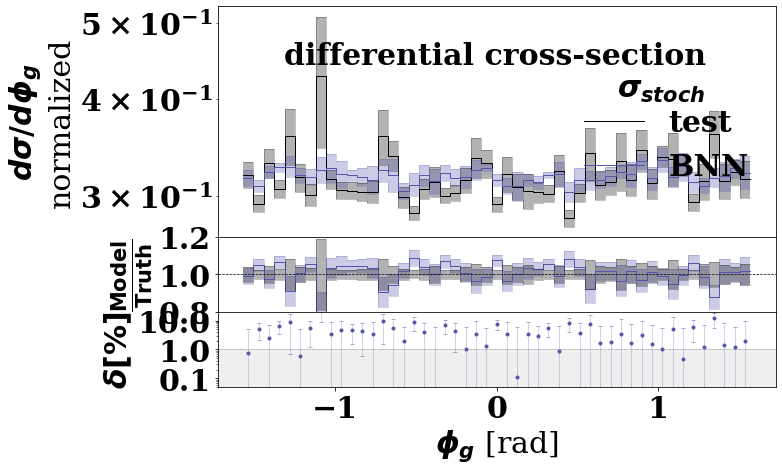

runtime: 2.11301 s


In [262]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="stoch", normalize=True, stoch_error=True, true_label=true_label, inner_text=inner_text)

amplitude error:  [ 1.28259535  2.21307825  0.82195276  1.48325561  2.39089692  0.9018675
 10.84800852  1.68351247  1.32686588  1.29596581  1.16506978  1.3323584
  2.6636877   1.51764181  4.97497445  1.01947498  0.92568964  6.82846048
  1.1969939   5.75015347]
events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


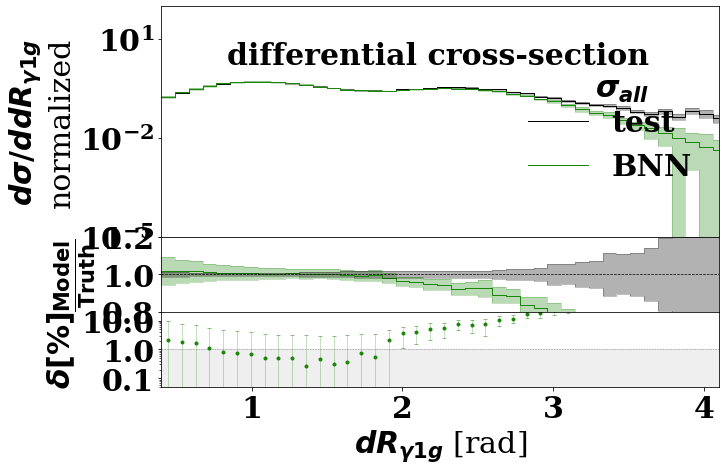

runtime: 90.81321 s


In [257]:
dR_true = obs_true[3]
dR = obs[3][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, true_label=true_label, inner_text=inner_text)

events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00941884 0.00850014 0.00749223
 0.0067394  0.00609268 0.00577908 0.00567999 0.00555649 0.00617949
 0.00646172 0.0068508  0.00716662 0.00713047 0.00695367 0.0063962
 0.00614705 0.00501412 0.00473014 0.00374502 0.00345834 0.00279569
 0.0024002  0.00208516 0.0019887

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


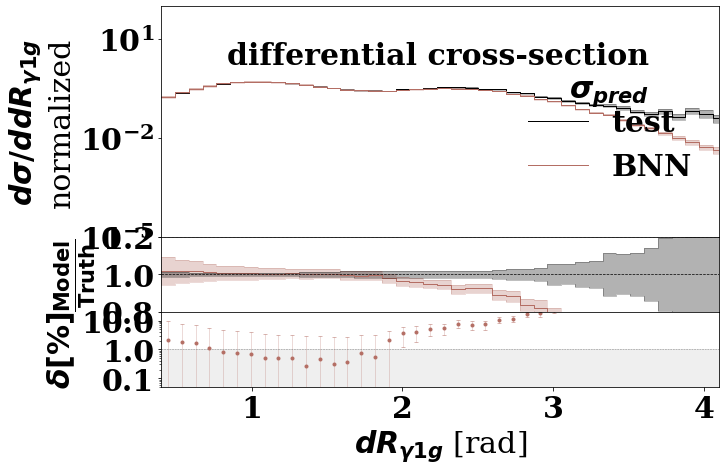

runtime: 2.20863 s


In [258]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="pred", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, 
                       true_label=true_label, inner_text=inner_text)

events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6573  5485  4964  5117  6003  6977  8037  9251  9733  9473  8819
  7576  5820  4447  3098  2154  1373   885   607   458   283   175   138
    91    56    46    29    25     9    13    10     3     3     0     0
     1]
true events:  [ 9745 13508 17099 20729 23094 23765 22854 21376 18818 15718 12656 10161
  8236  6575  5488  4966  5119  6014  6992  8055  9273  9771  9506  8844
  7617  5855  4504  3145  2198  1422   939   663   497   327   216   171
   124    83    84    59    42    24    38    25    11    11     8    13
     6]
bin_true:  [0.00368474 0.00492918 0.00625143 0.00774171 0.00926563 0.01018391
 0.01043038 0.01061231 0.01013076 0.00941884 0.00850014 0.00749223
 0.0067394  0.00609268 0.00577908 0.00567999 0.00555649 0.00617949
 0.00646172 0.0068508  0.00716662 0.00713047 0.00695367 0.0063962
 0.00614705 0.00501412 0.00473014 0.00374502 0.00345834 0.00279569
 0.0024002  0.00208516 0.0019887

<ipython-input-209-4bdffdcffb4b>:148: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


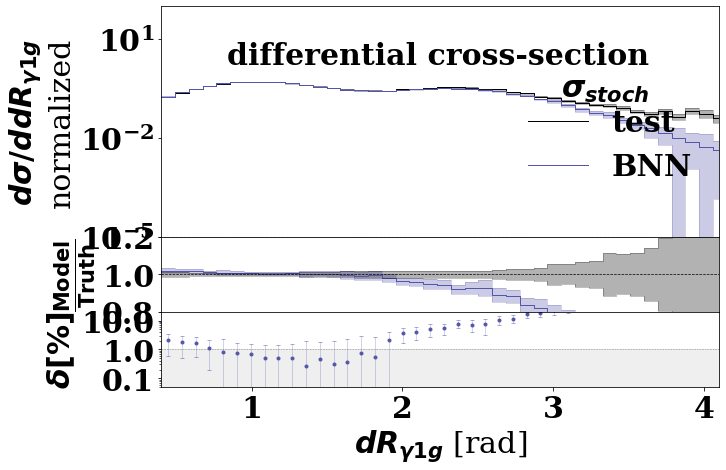

runtime: 2.22723 s


In [259]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="stoch", xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2), normalize=normalize, stoch_error=True, 
                       true_label=true_label, inner_text=inner_text)

# ALL Data in one BNN

target mean:  8.731405386919701e-07 
target std:  9.601961678485827e-06
[[85.59688446  1.17049559  2.34099118 85.57730806]
 [71.74694792  2.25314618  4.50629235 71.58830349]
 [56.70932244 57.14650919 58.09309951 48.94531817]
 [40.13229977 37.5806673  38.0388645  39.71913024]
 [63.08556411 47.94685682 47.66730845 66.54029033]] (5, 4)
min:  0.0025632204037534198
max:  40.00184520032217


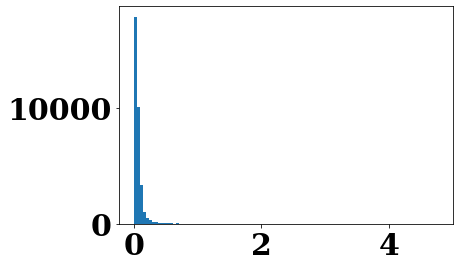

In [340]:
# network with divergent and non-divergent data in one
log_preprocessing = True
BNN_f = BNN
epochs = 150000
batch_size=4096
# NOTE: the above parameters have to be changed for different training


cut_training_data = np.load("cut_data/training_data.npy")
cut_training_amp = np.load("cut_data/training_amp.npy")

cut_test_data = np.load("cut_data/test_data.npy")
cut_test_amp = np.load("cut_data/test_amp.npy")

R_div = np.load("partitioned_data/R_div.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

R_non_div = np.load("partitioned_data/R_non_div.npy")
non_div_amp = np.load("partitioned_data/non_div_amp.npy")

jiggle_data = np.load("jiggle_data/jiggle_data.npy")
jiggle_amp = np.load("jiggle_data/jiggle_amp.npy")

data = np.concatenate((cut_training_data, jiggle_data), axis=0)
targets = np.concatenate((cut_training_amp, jiggle_amp), axis=0)

state_all, DL_all = train(epochs,batch_size, dataset=data, targets=targets, prior_prec=1/10, checkpoint_PATH=None, 
                   loadfile="checkpoint/log_softplus_all/ALL_JIGGLE_4096b_weights150000", shuffle=False, BNN_f=BNN_f, 
                          inner_layers=[20,30,40,20], log=log_preprocessing)

In [341]:
# ALWAYS CHANGE TO MATCH RIGHT BNN

bnn_all = BNN_f(R_non_div.shape[0], prior_prec=1/10, _map=False, inner_layers=[20,30,40,20], const_sigma=False).to(device)
bnn_all.load_state_dict(state_all)

Creating Network Layers: 
0 . layer: ( 20 20 )
1 . layer: ( 20 30 )
2 . layer: ( 30 40 )
3 . layer: ( 40 20 )
4 . layer: ( 20 2 )
layers:  Sequential(
  (0): VBLinear (20) -> (20)
  (1): Tanh()
  (2): VBLinear (20) -> (30)
  (3): Tanh()
  (4): VBLinear (30) -> (40)
  (5): Tanh()
  (6): VBLinear (40) -> (20)
  (7): Tanh()
  (8): VBLinear (20) -> (2)
) Softplus(beta=1, threshold=20)  created.


<All keys matched successfully>

In [342]:
# prepare all test data

valdata_all, valtargets_all = DL_all.test_data(dataset=cut_test_data, targets=cut_test_amp, shuffle=False)
training_valdata_all, training_valtargets_all = DL_all.test_data(dataset=cut_training_data, targets=cut_training_amp, shuffle=False)

using log preprocessing
using log preprocessing


# prepare div test data

test_R_div = np.load("partitioned_data/test_R_div.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")

valdata_all, valtargets_all = DL_all.test_data(dataset=test_R_div, targets=test_div_amp, shuffle=False)

# prepare non-div test data

test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")

valdata_all, valtargets_all = DL_all.test_data(dataset=test_R_non_div, targets=test_non_div_amp, shuffle=False)

In [346]:
# predict test data

# CHANGE BACK
_, sigma2_all, output_all = sample(sets=50, bnn=bnn_all, X=valdata_all, Y=valtargets_all, DL=DL_all, log=log_preprocessing) 
ratio_all = output_all.mean(axis=0)/cut_test_amp

# predict test data

_, sigma2_all, output_all= sample(sets=50, bnn=bnn_all, X=valdata_all, Y=valtargets_all, DL=DL_all, log=True, const_sigma=1e-12) 
ratio_all = output_all.mean(axis=0)/test_non_div_amp

In [347]:
ratio_all=ratio_all[ratio_all>0]
output_all = np.clip(output_all, 0,output_all.max()+10)

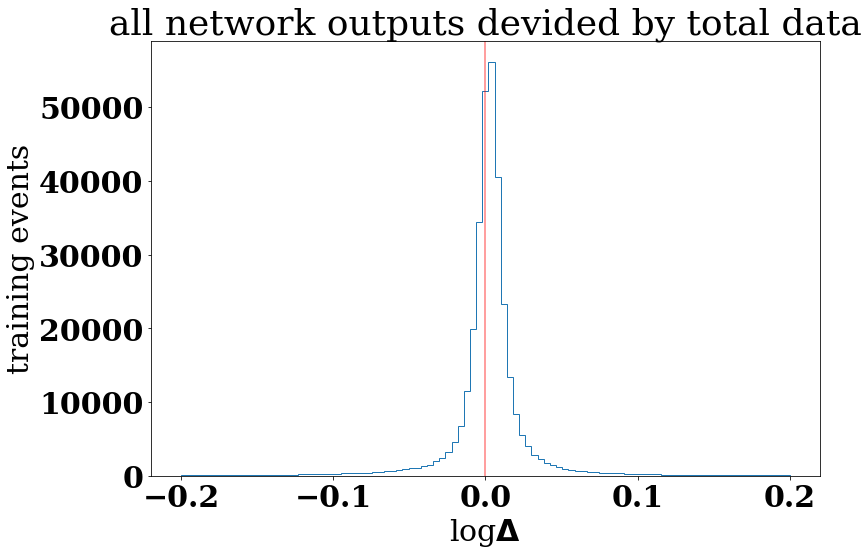

In [348]:
# consistency check

#ratio_non_div = output_non_div.mean(axis=0)/test_non_div_amp

plt.figure(figsize=(12,8))
_ = plt.hist(np.log(ratio_all), bins=np.linspace(-0.2,0.2,100), histtype="step")
plt.title("all network outputs devided by total data")  
plt.ylabel("training events")
plt.xlabel("log$\Delta$")
plt.axvline(0, alpha=0.5, c="r")
#plt.savefig("plots/cross_section/log_softplus_all/jiggle/total_performance.jpg")
plt.show()
#np.save("plots/cross_section/performance/log_softplus_all/jiggle/all.npy", ratio_all)

amplitude error:  [130.71096611 110.46508346 122.10332003 175.87965052 127.07503766
 104.97468798 133.54278196 122.94830218 117.33726454 120.6936135
 121.48440655  57.5152885  129.18224703 127.24684466 114.47167821
  99.70094449 149.77408545 113.46761332 127.92025096 127.25855934]
events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      

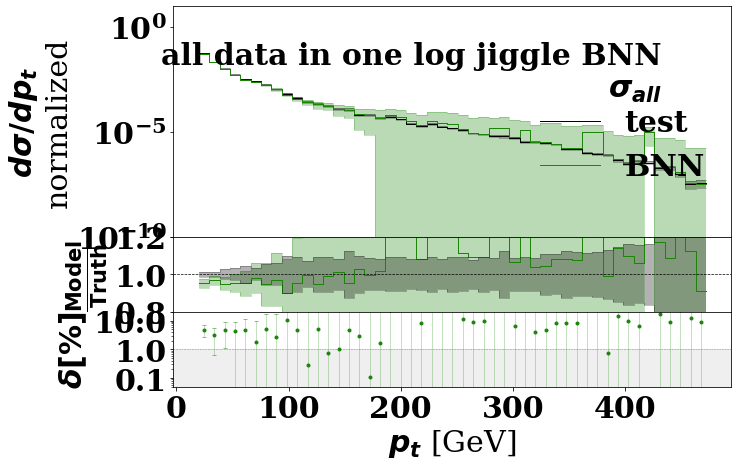

runtime: 86.96198 s


In [255]:

R_all = cut_test_data
R_all_training = cut_training_data
#R_all = test_R_non_div
#R_all = test_R_div

#amp_all = cut_training_amp
amp_all = cut_test_amp
#amp_all = test_non_div_amp
#amp_all = test_div_amp

all_output = output_all
sigma2_all = sigma2_all

'''
test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_R_div = np.load("partitioned_data/test_R_div.npy")
R_div = np.load("partitioned_data/R_div.npy")

# CHANGE BACK
R_all = np.concatenate((test_R_non_div, test_R_div), axis=0)

test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

# CHANGE BACK
amp_all = np.concatenate((test_non_div_amp, test_div_amp), axis=0)
'''

filter = np.full(R_all.shape[0], True)

'''
#filter
filter = get_filter(all_output, sigma2_all,8,10)
all_output = all_output[:,filter]
sigma2_all = sigma2_all[:,filter]
#R_all = R_all[filter]
#amp_all = amp_all[filter]
'''


save = "log_softplus_all/jiggle/vs_test"
filtered = ""
map = ""
less = ""
true_label="test"
normalize = False
#inner_text = "all data in one BNN"
inner_text = "all data in one log jiggle BNN"

obs_true = observables(R_all)
obs = observables(R_all)

p_t_true = obs_true[0]
p_t = obs[0][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_t{}{}{}.jpg".format(save, filtered, map, less),
                      xlabel="p_t", unit="GeV", errortype="all", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize, ylim=(1e-10, 10))


events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

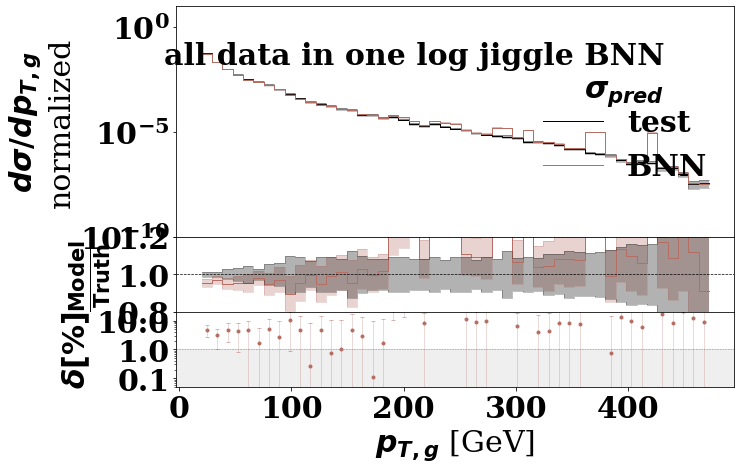

runtime: 2.34416 s


In [256]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_std.jpg".format(save, filtered, map, less),
                       xlabel="p_{T,g}", unit="GeV", errortype="pred", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize, ylim=(1e-10, 10))

events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
true events:  [102027  70089  46640  30896  21464  15719  10005   6047   3722   2508
   1882   1595   1326   1149   1068    915    867    755    728    672
    610    544    524    495    425    430    377    330    333    300
    279    237    235    192    183    128    143    121    105     84
     65     48     55     52     32     33     19      6      6]
bin_true:  [1.23092372e-01 4.70680917e-02 2.22799540e-02 1.16003866e-02
 7.09298861e-03 5.43870579e-03 3.78265156e-03 2.37017014e-03
 1.44400723e-03 8.62362044e-04 5.73291347e-04 4.59351337e-04
 3.78859689e-04 2.68400700e-04 2.48945226e-04 1.43361812e-04
 1.41457393e-04 9.980370

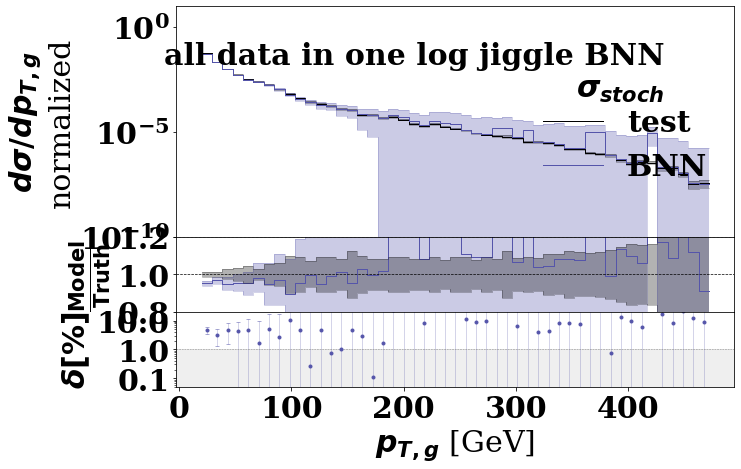

runtime: 2.34434 s


In [257]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=p_t[:,4], reference_true=p_t_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/p_T{}{}{}_bnn.jpg".format(save, filtered, map, less) , 
                       xlabel="p_{T,g}", unit="GeV", errortype="stoch", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize, ylim=(1e-10, 10))

amplitude error:  [0.46542722 1.29191111 0.85087059 0.16837293 2.3365079  0.42972746
 1.51422288 0.212973   2.71980883 3.30230532 4.69921965 0.86096712
 2.47364943 0.49524453 0.46358048 0.09926341 0.70165488 0.68762798
 0.10173634 0.13349716]
events:  [    6     8    10    13    40    40    61   108   154   248   435   672
  1045  1486  2174  3184  4506  5976  7979 10162 12479 14930 17382 18884
 19999 20856 21413 21316 21236 20568 18631 16795 14446 12203  9900  7779
  5936  4312  3110  2189  1407   998   589   382   213   110    60    25
    10]
true events:  [    6     8    10    13    40    40    61   108   154   248   435   672
  1045  1486  2174  3184  4506  5976  7979 10162 12479 14930 17382 18884
 19999 20856 21413 21316 21236 20568 18631 16795 14446 12203  9900  7779
  5936  4312  3110  2189  1407   998   589   382   213   110    60    25
    10]
bin_true:  [1.30511305e-03 9.54104725e-04 1.52713135e-03 1.84629352e-03
 1.71063730e-03 1.25771215e-03 1.79169864e-03 2.07689459e-03
 

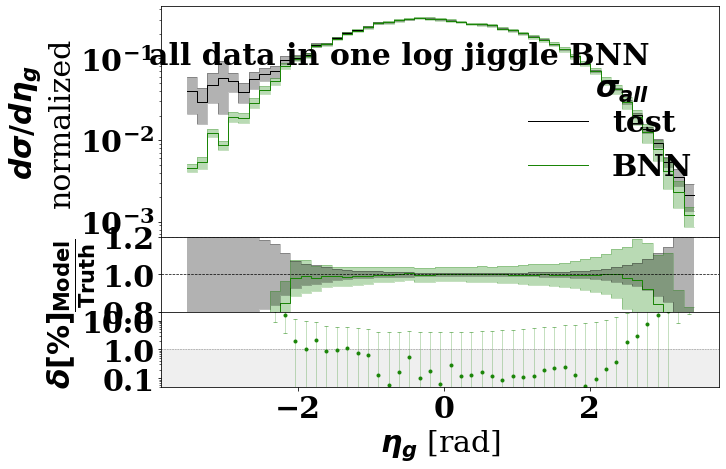

runtime: 87.03827 s


In [258]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize)

events:  [    6     8    10    13    40    40    61   108   154   248   435   672
  1045  1486  2174  3184  4506  5976  7979 10162 12479 14930 17382 18884
 19999 20856 21413 21316 21236 20568 18631 16795 14446 12203  9900  7779
  5936  4312  3110  2189  1407   998   589   382   213   110    60    25
    10]
true events:  [    6     8    10    13    40    40    61   108   154   248   435   672
  1045  1486  2174  3184  4506  5976  7979 10162 12479 14930 17382 18884
 19999 20856 21413 21316 21236 20568 18631 16795 14446 12203  9900  7779
  5936  4312  3110  2189  1407   998   589   382   213   110    60    25
    10]
bin_true:  [1.30511305e-03 9.54104725e-04 1.52713135e-03 1.84629352e-03
 1.71063730e-03 1.25771215e-03 1.79169864e-03 2.07689459e-03
 2.24471319e-03 3.11485482e-03 3.29543318e-03 3.52793651e-03
 4.75562471e-03 4.86448835e-03 5.69387473e-03 6.55924929e-03
 7.15823957e-03 7.84573731e-03 8.80183835e-03 8.98980898e-03
 9.44608570e-03 9.78961611e-03 1.00939067e-02 9.93444586e-03


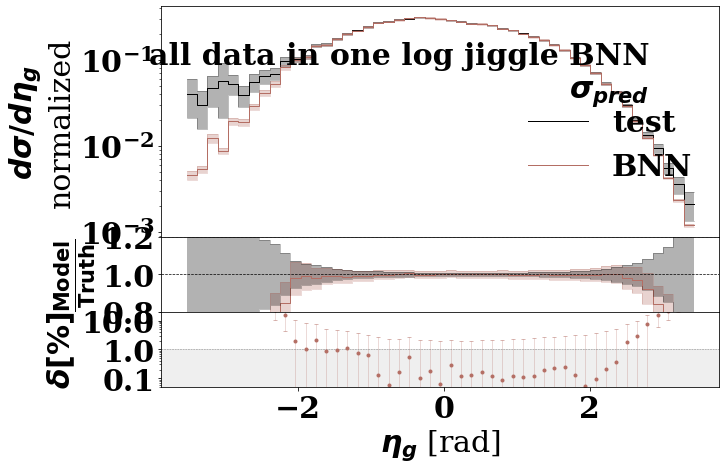

runtime: 2.44044 s


In [259]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="pred", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize)

events:  [    6     8    10    13    40    40    61   108   154   248   435   672
  1045  1486  2174  3184  4506  5976  7979 10162 12479 14930 17382 18884
 19999 20856 21413 21316 21236 20568 18631 16795 14446 12203  9900  7779
  5936  4312  3110  2189  1407   998   589   382   213   110    60    25
    10]
true events:  [    6     8    10    13    40    40    61   108   154   248   435   672
  1045  1486  2174  3184  4506  5976  7979 10162 12479 14930 17382 18884
 19999 20856 21413 21316 21236 20568 18631 16795 14446 12203  9900  7779
  5936  4312  3110  2189  1407   998   589   382   213   110    60    25
    10]
bin_true:  [1.30511305e-03 9.54104725e-04 1.52713135e-03 1.84629352e-03
 1.71063730e-03 1.25771215e-03 1.79169864e-03 2.07689459e-03
 2.24471319e-03 3.11485482e-03 3.29543318e-03 3.52793651e-03
 4.75562471e-03 4.86448835e-03 5.69387473e-03 6.55924929e-03
 7.15823957e-03 7.84573731e-03 8.80183835e-03 8.98980898e-03
 9.44608570e-03 9.78961611e-03 1.00939067e-02 9.93444586e-03


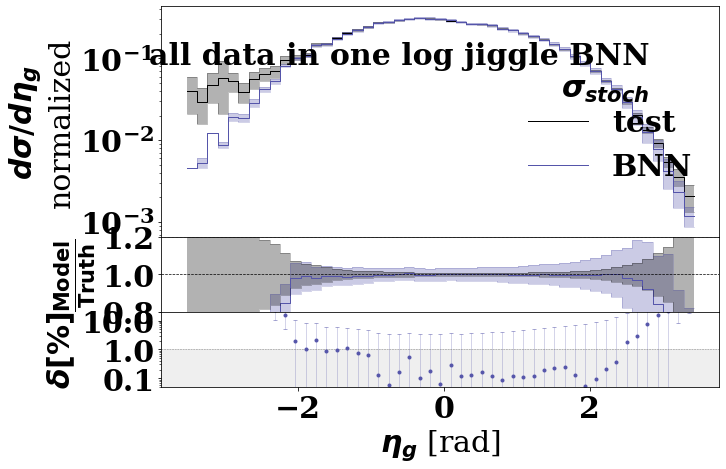

runtime: 2.37865 s


In [260]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=eta[:,4], reference_true=eta_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\eta_g", unit="rad", errortype="stoch", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize)

amplitude error:  [2.22426228e+00 2.78711150e+01 4.15516999e+00 1.75994053e+00
 2.97360218e+00 3.13723131e+01 1.05911580e+01 5.83340574e-01
 9.51748225e-01 4.22771017e-04 8.27199560e+00 9.18672844e-01
 2.20315538e+00 6.28994788e+00 8.69582603e+00 8.99076664e-01
 1.76298055e+01 4.23226690e-04 4.22760845e-04 4.24581754e-04]
events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e

<ipython-input-131-f485e9318bf7>:152: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


saved:  plots/cross_section/log_softplus_all/jiggle/vs_test/eta_diff.jpg


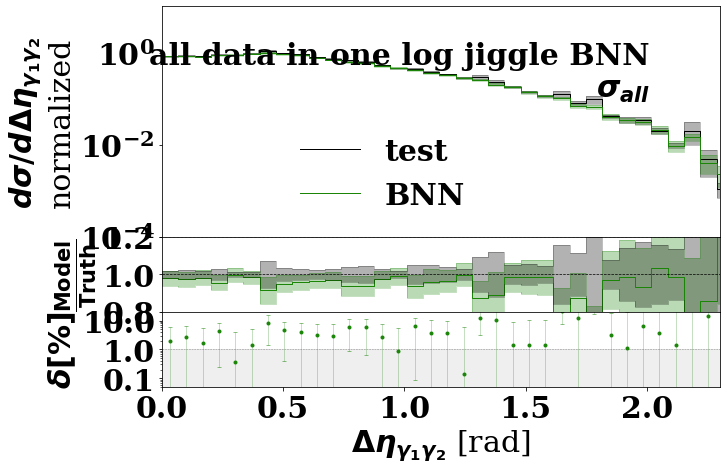

runtime: 84.43705 s


In [261]:
eta_true = obs_true[1]
eta = obs[1][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", inner_text=inner_text, true_label=true_label, ylim=(1e-4,10), xlim=(0,2.3), stoch_error=True, 
                       legend_pos="best", normalize=normalize)

events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-131-f485e9318bf7>:152: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


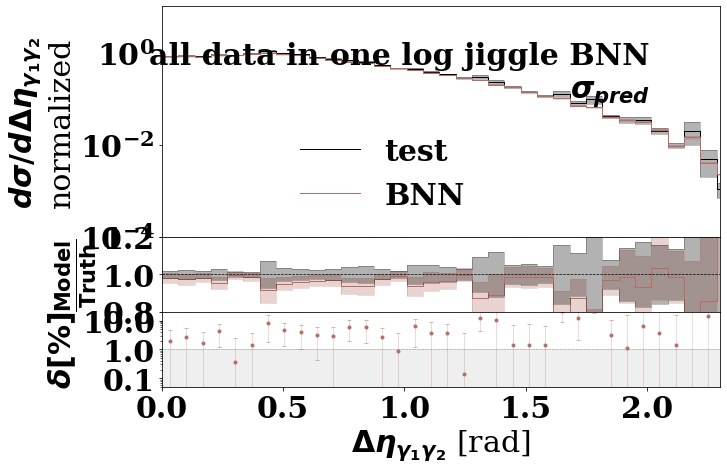

runtime: 2.20781 s


In [262]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="pred", inner_text=inner_text, true_label=true_label, ylim=(1e-4,10), xlim=(0,2.3), stoch_error=True, 
                       legend_pos="best", normalize=normalize)

events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
true events:  [25891 25140 24590 24367 23922 24132 23256 21207 19175 16962 15154 13362
 11472 10023  8634  7504  6177  5180  4373  3603  2884  2269  1829  1388
  1099   838   622   455   320   252   173   101    69    27    12     1
     0     0     0     0     1     0     0     0     0     0     0     0
     1]
bin_true:  [1.28099931e-02 1.30283884e-02 1.27537713e-02 1.38081097e-02
 1.34903468e-02 1.45514293e-02 1.64277243e-02 1.47769531e-02
 1.40597542e-02 1.22013443e-02 1.10905447e-02 1.02874824e-02
 9.63631835e-03 8.07113254e-03 7.04331707e-03 6.83363431e-03
 5.78478693e-03 5.14594080e-03 4.28640312e-03 4.47032908e-03
 3.44650415e-03 2.76877476e-03 2.16241318e-03 1.73123027e-03


<ipython-input-131-f485e9318bf7>:152: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


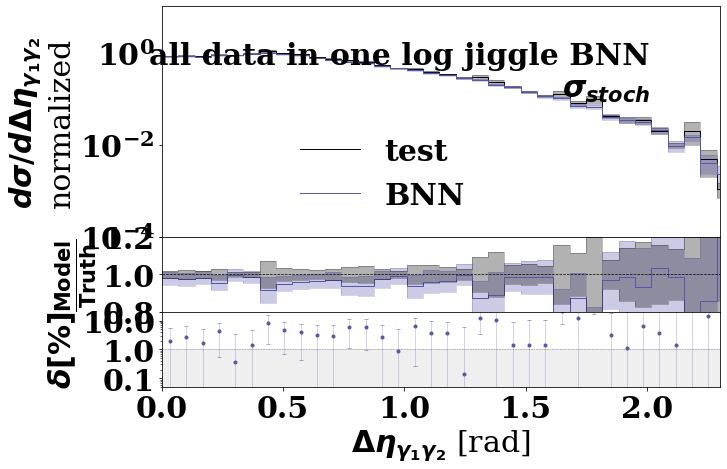

runtime: 2.34164 s


In [263]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=np.abs(eta[:,3]-eta[:,2]), reference_true=np.abs(eta_true[:,3]-eta_true[:,2]), bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/eta_diff{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\Delta \eta_{\gamma_1\gamma_2}", unit="rad", errortype="stoch", inner_text=inner_text, true_label=true_label, ylim=(1e-4,10), xlim=(0,2.3), stoch_error=True,
                       legend_pos="best", normalize=normalize)

amplitude error:  [ 9.2706822   3.46559254  4.14069427  8.66119406  2.82048961  3.71450463
  2.95333115  6.77453615  3.44752767 16.03214987  2.51744842  7.84289639
  1.97866312 10.03060207  3.84435449  3.00624747  4.66926412  3.62067536
  3.85477182  6.80955374]
events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.

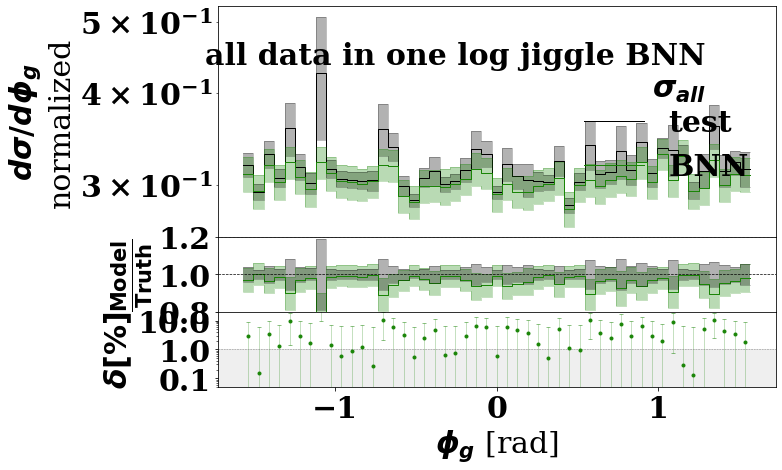

runtime: 86.89660 s


In [264]:
phi_true = obs_true[2]
phi = obs[2][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize)

events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

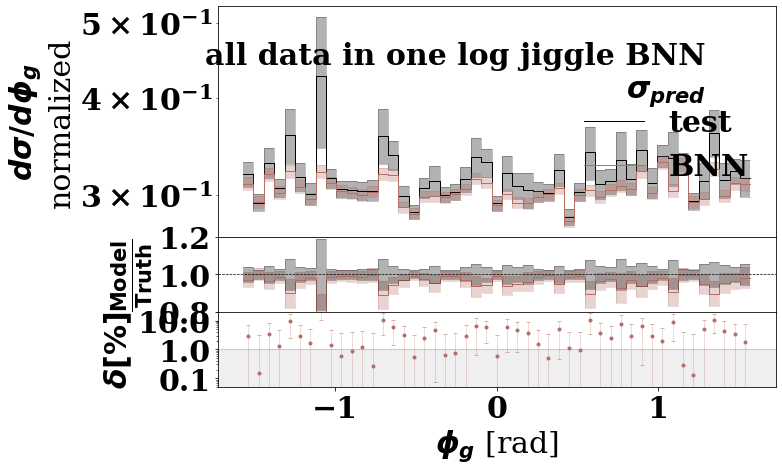

runtime: 2.24096 s


In [265]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="pred", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize)

events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
true events:  [6744 6624 6838 6696 6748 6667 6633 6700 6699 6625 6677 6565 6641 6655
 6731 6388 6546 6576 6595 6709 6584 6662 6773 6773 6480 6514 6484 6589
 6622 6747 6697 6456 6628 6517 6559 6642 6654 6711 6801 6667 6834 6653
 6794 6730 6548 6773 6743 6915 6858]
bin_true:  [0.0046652  0.00428845 0.00482793 0.00447845 0.00523312 0.0046326
 0.00440461 0.00623935 0.00460601 0.00446258 0.00445326 0.00444174
 0.00444218 0.00523012 0.00493943 0.00436818 0.00417467 0.00448058
 0.00457679 0.0043872  0.00443067 0.00459271 0.00491182 0.00483001
 0.00427828 0.0046793  0.00450786 0.00444974 0.0044321  0.00441518
 0.00472527 0.0041063  0.00442568 0.00497437 0.00452888 0.00456506
 0.00486783 0.00459701 0.00501601 0.00455057 0.00492544 0.0048958

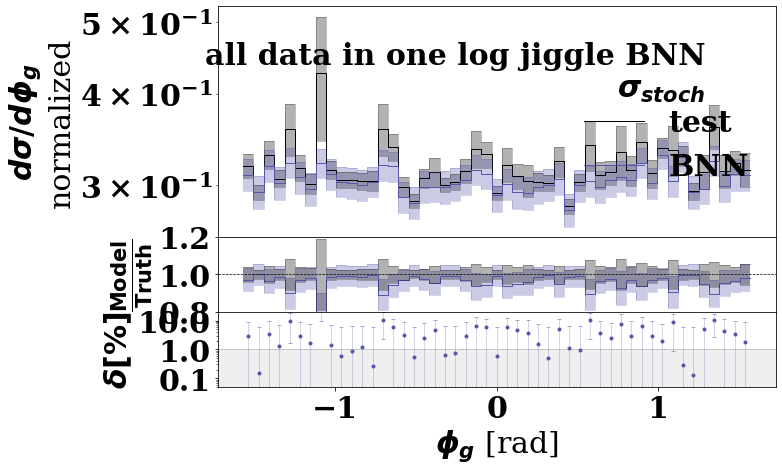

runtime: 2.43856 s


In [266]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=phi[:,4], reference_true=phi_true[:,4], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/phi{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="\phi_g", unit="rad", errortype="stoch", inner_text=inner_text, true_label=true_label, stoch_error=True, normalize=normalize)

amplitude error:  [2.51532100e-08 2.07804324e-05 3.87823955e-02 7.57500972e-10
 1.22893170e-02 3.08015233e-06 1.50805201e-07 2.09575996e-02
 1.49342485e-03 2.48239614e-04 5.13262355e-06 4.39550762e-07
 2.41812764e-04 4.41703628e-04 4.26149451e-05 4.86981603e-05
 1.48600180e-03 1.27101580e-05 8.29516684e-04 9.82390116e-03]
events:  [13200 19332 25237 29601 30205 28403 24671 19636 14974 11215  8525  6795
  6330  7555  9037 11013 12432 12231 10974  8639  6113  3888  2457  1405
   881   580   352   225   149   119    78    57    39    41    16    13
    12    13     9     2     3     1     2     2     1     0     0     0
     2]
true events:  [13200 19332 25237 29601 30205 28403 24671 19636 14974 11215  8525  6795
  6330  7555  9037 11013 12432 12231 10974  8639  6113  3888  2457  1405
   881   580   352   225   149   119    78    57    39    41    16    13
    12    13     9     2     3     1     2     2     1     0     0     0
     2]
bin_true:  [4.92592675e-03 7.04651377e-03 9.38789885e

<ipython-input-131-f485e9318bf7>:152: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


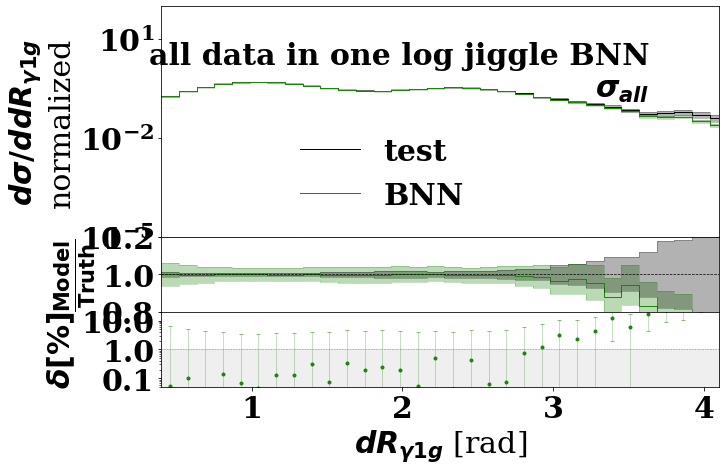

runtime: 88.16966 s


In [267]:
dR_true = obs_true[3]
dR = obs[3][filter]
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", inner_text=inner_text, true_label=true_label, stoch_error=True, legend_pos="best", 
                       normalize=normalize, xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2))

events:  [13200 19332 25237 29601 30205 28403 24671 19636 14974 11215  8525  6795
  6330  7555  9037 11013 12432 12231 10974  8639  6113  3888  2457  1405
   881   580   352   225   149   119    78    57    39    41    16    13
    12    13     9     2     3     1     2     2     1     0     0     0
     2]
true events:  [13200 19332 25237 29601 30205 28403 24671 19636 14974 11215  8525  6795
  6330  7555  9037 11013 12432 12231 10974  8639  6113  3888  2457  1405
   881   580   352   225   149   119    78    57    39    41    16    13
    12    13     9     2     3     1     2     2     1     0     0     0
     2]
bin_true:  [4.92592675e-03 7.04651377e-03 9.38789885e-03 1.18369338e-02
 1.31630216e-02 1.35544451e-02 1.31239923e-02 1.19188146e-02
 1.04708578e-02 8.82788716e-03 7.85594137e-03 7.42055082e-03
 7.13085320e-03 7.79052986e-03 8.28168749e-03 8.82787755e-03
 9.34176003e-03 8.96434238e-03 8.16870974e-03 7.15041786e-03
 6.09055827e-03 4.66000484e-03 4.07985751e-03 3.40641346e-03


<ipython-input-131-f485e9318bf7>:152: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


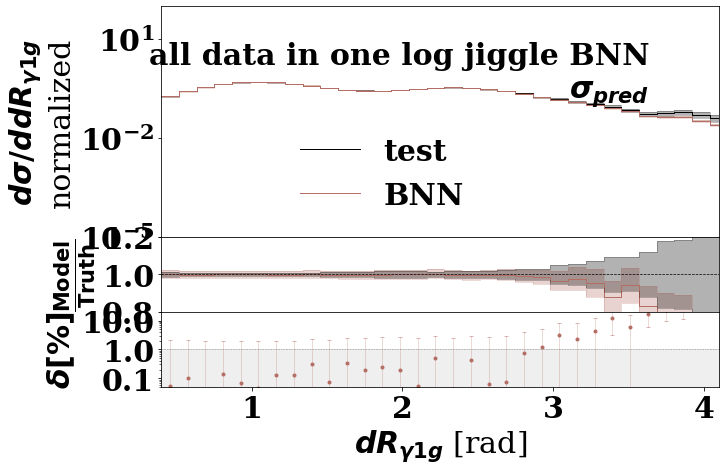

runtime: 2.38483 s


In [268]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_std.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="pred", inner_text=inner_text, true_label=true_label, stoch_error=True, legend_pos="best", 
                      normalize=normalize, xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2))

events:  [13200 19332 25237 29601 30205 28403 24671 19636 14974 11215  8525  6795
  6330  7555  9037 11013 12432 12231 10974  8639  6113  3888  2457  1405
   881   580   352   225   149   119    78    57    39    41    16    13
    12    13     9     2     3     1     2     2     1     0     0     0
     2]
true events:  [13200 19332 25237 29601 30205 28403 24671 19636 14974 11215  8525  6795
  6330  7555  9037 11013 12432 12231 10974  8639  6113  3888  2457  1405
   881   580   352   225   149   119    78    57    39    41    16    13
    12    13     9     2     3     1     2     2     1     0     0     0
     2]
bin_true:  [4.92592675e-03 7.04651377e-03 9.38789885e-03 1.18369338e-02
 1.31630216e-02 1.35544451e-02 1.31239923e-02 1.19188146e-02
 1.04708578e-02 8.82788716e-03 7.85594137e-03 7.42055082e-03
 7.13085320e-03 7.79052986e-03 8.28168749e-03 8.82787755e-03
 9.34176003e-03 8.96434238e-03 8.16870974e-03 7.15041786e-03
 6.09055827e-03 4.66000484e-03 4.07985751e-03 3.40641346e-03


<ipython-input-131-f485e9318bf7>:152: RuntimeWarning: invalid value encountered in true_divide
  print("error: ", np.sqrt(bin_variance)/bin_mean)


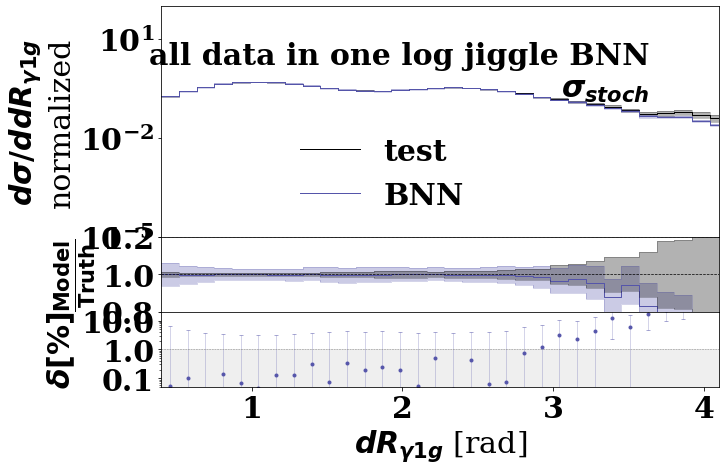

runtime: 2.44214 s


In [269]:
_ = plot_differential2(amplitudes=all_output, true_amplitudes=amp_all, sigma2=sigma2_all, reference=dR[:,8], reference_true=dR_true[:,8], bins=50, label="test", samplesize=50, savepath="plots/cross_section/{}/dR{}{}{}_bnn.jpg".format(save, filtered, map, less), 
                       xlabel="dR_{\gamma 1 g}", unit="rad", errortype="stoch", inner_text=inner_text, true_label=true_label, stoch_error=True, legend_pos="best", 
                      normalize=normalize, xlim=(dR[:,8].min(), 4.1), ylim=(1e-5,1e2))

### test on divergent space







In [307]:
test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_R_div = np.load("partitioned_data/test_R_div.npy")
cut_test_data = np.load("cut_data/test_data.npy")

In [308]:
R = np.concatenate((test_R_non_div, test_R_div), axis=0).reshape(-1,20)
cdata = cut_test_data.reshape(-1,20)

In [312]:
test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")
R_div = np.load("partitioned_data/R_div.npy")
div_amp = np.load("partitioned_data/div_amp.npy")

In [316]:
# prepare all test data

valdata_div, valtargets_div = DL_all.test_data(dataset=test_R_div, targets=test_div_amp, shuffle=False)
training_valdata_div, training_valtargets_div = DL_all.test_data(dataset=R_div, targets=div_amp, shuffle=False)

using log preprocessing
using log preprocessing


In [317]:
# predict non-divergent test data
# CHANGE BACK
_, sigma2_div, output_div = sample(sets=500, bnn=bnn_all, X=valdata_div, Y=valtargets_div, DL=DL_all, log=True) 
ratio_div = output_div.mean(axis=0)/test_div_amp

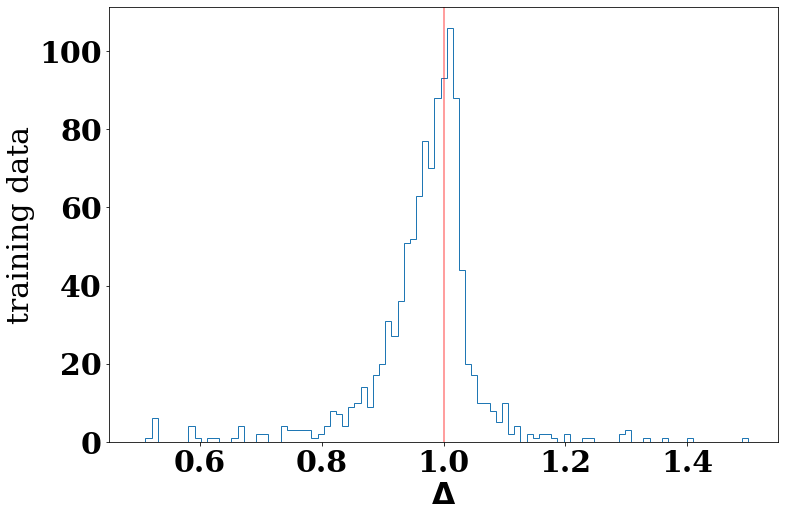

In [322]:
# consistency check

plt.figure(figsize=(12,8))
_ = plt.hist(ratio_div, bins=np.linspace(0.5,1.5,100), histtype="step")
#plt.ylabel("test events")
plt.xlabel("$\Delta$")
plt.ylabel("training data")
plt.axvline(1, alpha=0.5, c="r")
plt.text(0.5, 750, "One BNN prediction of \ndivergent area", fontsize="small", fontstyle="normal", fontweight=500)
plt.text(1.1, 750, "Log all in one BNN", fontsize="small", fontstyle="normal", fontweight=500)
#plt.savefig("plots/cross_section/log_softplus_all/jiggle/training_div_performance.jpg")
plt.show()
#np.save("plots/cross_section/performance/linear_no_act_all/divergent.npy", ratio_div)

In [329]:
# test on NON divergent space







In [330]:
test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")
test_R_div = np.load("partitioned_data/test_R_div.npy")
cut_test_data = np.load("cut_data/test_data.npy")

In [331]:
R = np.concatenate((test_R_non_div, test_R_div), axis=0).reshape(-1,20)
cdata = cut_test_data.reshape(-1,20)

In [333]:
test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_div_amp = np.load("partitioned_data/test_div_amp.npy")
R_non_div = np.load("partitioned_data/R_non_div.npy")
non_div_amp = np.load("partitioned_data/non_div_amp.npy")

In [334]:
# prepare all test data

valdata_non_div, valtargets_non_div = DL_all.test_data(dataset=test_R_non_div, targets=test_non_div_amp, shuffle=False)
training_valdata_non_div, training_valtargets_non_div = DL_all.test_data(dataset=R_non_div, targets=non_div_amp, shuffle=False)

using log preprocessing
using log preprocessing


In [335]:
# predict non-divergent test data

_, sigma2_non_div, output_non_div = sample(sets=500, bnn=bnn_all, X=training_valdata_non_div, Y=training_valtargets_non_div, DL=DL_all, log=True) 
ratio_non_div = output_non_div.mean(axis=0)/non_div_amp

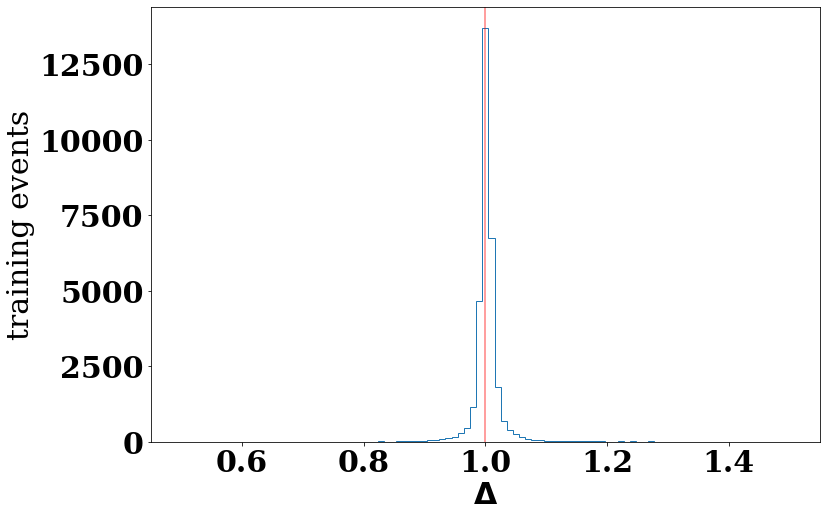

In [339]:
# consistency check

plt.figure(figsize=(12,8))
_ = plt.hist(ratio_non_div, bins=np.linspace(0.5,1.5,100), histtype="step")
plt.ylabel("training events")
plt.xlabel("$\Delta$")
plt.axvline(1, alpha=0.5, c="r")
#plt.text(0.5, 100000, "One BNN prediction of \nnon-divergent area", fontsize="small", fontstyle="normal", fontweight=500)
#plt.text(1.1, 100000, "Log all in one BNN", fontsize="small", fontstyle="normal", fontweight=500)
#plt.savefig("plots/cross_section/log_softplus_all/jiggle/training_non_div_performance.jpg")
plt.show()
#np.save("plots/cross_section/performance/linear_no_act_all/non_divergent.npy", ratio_non_div)

# Error Training Size plot (training size - mean error)

# legacy function (works but is ineffective)

@runtime
def differential_all_error(amplitudes, sigma2, true_amplitudes, samplesize=50):
    
    '''
    compute all, stoch and pred error for each output
    
    amplitudes      :: [array-like] :: set of sampled amplitudes dim=(setsize,data)
    true_amplitudes :: [array-like] :: true amplitudes dim=(data)
    sigma2          :: [array-like] :: set of squared sigmas of the amplitudes dim=(setsize,data)
    bins            :: [int]        :: amount of bins
    samplesize      :: [int]        :: amount of samplings in per BNN result
    errortype       :: [errortype]  :: "normal", "std" or "bnn" -> calculate exclusively these errors
    '''
    
    sets = amplitudes.shape[0]
    N = amplitudes.shape[1]
    amplitude_err = np.sqrt(sigma2)

    
    sampled_bin_amplitude = np.empty(N)
    
    # stoch error
    bin_variance = np.zeros((sets, N))
    bin_mean = np.zeros((sets, N))
    
    for set in range(sets):
        for sample in range(samplesize):
            sampled_bin_amplitude = amplitudes[set]+amplitude_err[set]*np.random.normal(loc=0, scale=1, size=N)

            bin_mean[set] += sampled_bin_amplitude
    bin_mean  /= samplesize

    #bin_mean = bin_mean*(reference.max()-reference.min())/bins


    # todo: this is inefficient but fine for now

    for set in range(sets):
        for sample in range(samplesize):
            sampled_bin_amplitude = amplitudes[set]+amplitude_err[set]*np.random.normal(loc=0, scale=1, size=N)

            bin_variance[set] += (bin_mean[set]-sampled_bin_amplitude)**2

    bin_variance /= (samplesize)

    bin_variance = np.mean(bin_variance, axis=0)
    bin_mean = np.mean(bin_mean, axis=0)
    
    plt.hist(bin_variance)
    plt.yscale("log")
    plt.show()
    stoch_error = bin_variance.mean()
    
    # all error
    bin_variance = np.zeros(N)
    
    #bin_mean = bin_mean.mean(axis=0)

    for set in range(sets):
        for sample in range(samplesize):
            sampled_bin_amplitude = amplitudes[set]+amplitude_err[set]*np.random.normal(loc=0, scale=1, size=N)

            bin_variance += (bin_mean-sampled_bin_amplitude)**2
    bin_variance /= (sets*samplesize)
    
    plt.hist(bin_variance)
    plt.yscale("log")
    plt.show()
    all_error = bin_variance.mean()
    
    # pred error
    bin_mean = np.zeros(N)
    bin_variance = np.zeros(N)
    
    
    for set in range(sets):
        sampled_bin_amplitude = amplitudes[set]

        
        bin_mean += sampled_bin_amplitude
    bin_mean = bin_mean/(sets)

    #bin_mean = bin_mean*(reference.max()-reference.min())/bins

    for set in range(sets):
        sampled_bin_amplitude = amplitudes[set]

        bin_variance += (bin_mean-sampled_bin_amplitude)**2
    bin_variance /= (sets)
    
    plt.hist(bin_variance)
    plt.yscale("log")
    plt.show()
    pred_error = bin_variance.mean()
    
    
    
    return all_error, pred_error, stoch_error

# import reduced data

data_full = "checkpoint/softplus/less_data/4096b_weights50000"
data_2    = "checkpoint/softplus/less_data/2_4096b_weights100000"
data_5    = "checkpoint/softplus/less_data/5_1024b_weights30000"
data_10   = "checkpoint/softplus/less_data/10_1024b_weights100000"
data_20   = "checkpoint/softplus/less_data/20_256b_weights50000"
data_40   = "checkpoint/softplus/less_data/40_128b_weights50000"
data_50   = "checkpoint/softplus/less_data/50_128b_weights50000"
data = [data_full, data_2, data_5, data_10, data_20, data_40, data_50]
fractions = [1, 2, 5, 10, 20, 40, 50]


test_non_div_amp = np.load("partitioned_data/test_non_div_amp.npy")
test_R_non_div = np.load("partitioned_data/test_R_non_div.npy")

amp_all = test_non_div_amp

def error_means(data, fractions):
    '''
    compute mean error of all network outputs
    '''
    
    all_error = np.zeros(len(data))
    pred_error = np.zeros(len(data))
    stoch_error = np.zeros(len(data))
    mse = np.zeros(len(data))

    for it in range(len(fractions)):
        N = int(R_non_div.shape[0]/fractions[it]) 
        state, DL_non_div = train(10000,100, dataset=R_non_div[:N], targets=non_div_amp[:N], prior_prec=1/10, loadfile=data[it], shuffle=False)
        bnn_non_div = BNN(R_non_div.shape[0], prior_prec=1/10, _map=False).to(device)
        bnn_non_div.load_state_dict(state)

        # prepare non-divergent test data

        valdata, valtargets = DL_non_div.test_data(dataset=test_R_non_div, targets=test_non_div_amp, shuffle=False)

        # predict non-divergent test data

        _, sigma2_non_div, output_non_div = sample(sets=50, bnn=bnn_non_div, X=valdata, Y=valtargets, DL=DL_non_div) 
        #_, sigma2_non_div, output_non_div = _.mean(axis=0), sigma2_non_div.mean(axis=0), output_non_div.mean(axis=0)

        all_output = output_non_div
        sigma2_all = sigma2_non_div

        
        filter = get_filter(all_output, sigma2_all, 10,1e19)
        all_output = all_output[:,filter]
        sigma2_all = sigma2_all[:,filter]
        amp_all = test_non_div_amp[filter]
        
        
        all_error[it], pred_error[it], stoch_error[it] = differential_all_error(amplitudes=all_output, sigma2=sigma2_all, true_amplitudes=amp_all, samplesize=50)
        print("iteration done: ", it+1)
        
        mse[it] = np.mean((non_div_amp[:N]-non_div_amp[:N])**2)
        
    return all_error, pred_error, stoch_error, mse

all_error, pred_error, stoch_error, mse = error_means(data, fractions)

plt.figure(figsize=(12,8))
f = np.full(7, True)
f[2] = False
plt.plot((R_non_div.shape[0]/np.array(fractions)/1000)[f], all_error[f], label="all")
plt.plot((R_non_div.shape[0]/np.array(fractions)/1000)[f], stoch_error[f], label="stoch")
plt.plot((R_non_div.shape[0]/np.array(fractions)/1000)[f], pred_error[f], label="pred")
plt.plot((R_non_div.shape[0]/np.array(fractions)/1000)[f], mse[f], label="mse")
plt.yscale("log")
plt.xlabel("training size e3")
plt.ylabel("error")
plt.legend()
#plt.savefig("plots/cross_section/error_trainingsize_filtered.jpg", bbox_inches='tight')
plt.show()

plt.plot(R_non_div.shape[0]/np.array(fractions), 5e-12/np.sqrt(50000/np.array(fractions)))
plt.yscale("log")

all_error, pred_error, stoch_error, mse = error_means2(data, fractions)

plt.figure(figsize=(9,6))
plt.plot(R_non_div.shape[0]/np.array(fractions), all_error, label="all")
plt.plot(R_non_div.shape[0]/np.array(fractions), stoch_error, label="stoch")
plt.plot(R_non_div.shape[0]/np.array(fractions), pred_error, label="pred")
plt.plot(R_non_div.shape[0]/np.array(fractions), mse, label="mse")
plt.yscale("log")
plt.xlabel("training size")
plt.ylabel("error")
plt.legend()
#plt.savefig("plots/cross_section/error_trainingsize_filtered.jpg")
plt.show()